<a id='toc'></a>
# Список тестов по бригадам:

1. [Расчет процента подвязки между бригадами и локомотивами.](#perc_assign)
2. [Расчет процента запланированных бригад от общего количества бригад на входе планировщика.](#perc_assign2)
3. [Распределение между реальными и фейковыми бригадами в результатах планирования.](#real_fake)
4. [Составление списка станций и участков, на которых не состоялась подвязка бригады.](#no_assign)
5. [Проверка переработки бригад.](#overwork)   
6. [Проверка "скачков" бригад между станциями.](#leaps)
7. [Анализ времен стоянок поездов для смены бригады.](#stop_time)
8. [Анализ времен отдыха бригад.](#rest_time)
9. [Проверка корректности времен явки бригад во входных данных](#ready_time)
10. [Проверка смены бригад на корректных станциях](#change)
11. [Проверка отправления бригад до времени явки](#presence)
12. [Проверка планирования бригад до времени начала планирования](#before_current_time)
13. [Проверка планируемых явок бригад](#presenting)
14. [Проверка использования бригад после засылки пассажирами](#check_useful_assign)
  1. [Бригады, бесцельно отправляемые пассажирами](#only_pass)
  2. [Бригады, у которых запланирована только явка](#only_presence)
15. [Проверка подвязки негрузовых бригад](#pass_teams_in_plan)
16. [Проверка сохранения предыдущих времен явок](#Проверка-сохранения-предыдущих-времен-явок)
17. [Проверка возврата правильных времен явок у бригад](#Проверка-возврата-правильных-времен-явок-у-бригад)
18. [Проверка планирования УТХ бригад](#Проверка-планирования-УТХ-бригад)

### Константы и настройки

In [381]:
report = ''               # здесь будет храниться весь html-код отчета
FOLDER = 'resources/'     # папка с csv-файлами с данными
REPORT_FOLDER = 'report/' # папка для отчетов
PRINT = True              # выводить ли все таблицы из отчета на печать здесь в блокноте

In [382]:
TIME_FORMAT = '%b %d, %H:%M'
'''
    Преобразует время из timestamp в красивый формат, заданный в константе time_format
'''
def nice_time(t):
    return time.strftime(TIME_FORMAT, time.localtime(t)) if t > 0 else ''

def nice_print(s, **kwargs):    
    num = kwargs['num'] if 'num' in kwargs.keys() else False
    cols = kwargs['cols'] if 'cols' in kwargs.keys() else s.columns
    if num:
        print(s.reset_index()[cols].to_string())
    else:
        print(s[cols].to_string(index=False))

### Функции для экспорта в HTML

In [383]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="30%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

## Загрузка и подготовка данных

In [384]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv')
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                                 'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')

team_info.regions = team_info.regions.apply(literal_eval)
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
print('Время составления отчета:', time.strftime(TIME_FORMAT, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (nice_time(current_time), current_time))

Время составления отчета: Aug 12, 15:46
Время запуска планировщика: Aug 11, 19:31 (1470933101)


In [385]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_f'] = df.time_start.apply(lambda x: nice_time(x))
    if 'time_end' in df.columns:
        df['time_end_f'] = df.time_end.apply(lambda x: nice_time(x))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

In [386]:
add_line('Время сбора данных и запуска планировщика: %s' % nice_time(current_time))

Время сбора данных и запуска планировщика: Aug 11, 19:31


<a id='perc_assign'></a>
## Расчет процента подвязки между локомотивами и бригадами [ToC](#toc)

In [387]:
add_header('Расчет процента подвязки между локомотивами и бригадами', h=2, p=False)

In [388]:
def count_real_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             ((loco_plan.team == -1) | (loco_plan.team_type == 'Фейковая')) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без реальных бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    
    
def count_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             (loco_plan.team == -1) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    count_real_assign_percent(hor)   

    
if 'team' not in loco_plan.columns:
    loco_plan = loco_plan.set_index(['loco', 'time_start']).join(team_plan.loc[team_plan.state == 1, \
                                                                ['team', 'loco', 'time_start', 'team_type']].\
                                                                 set_index(['loco', 'time_start'])).reset_index()    
    loco_plan.team.fillna(-1, inplace=True)

count_assign_percent(6 * 3600)
count_assign_percent(12 * 3600)
count_assign_percent(24 * 3600)

Локомотивов без бригад на горизонте  6 часов: 61 из 1656 (процент подвязки 96%)
Локомотивов без реальных бригад на горизонте  6 часов: 206 из 1656 (процент подвязки 87%)
Локомотивов без бригад на горизонте 12 часов: 109 из 1656 (процент подвязки 93%)
Локомотивов без реальных бригад на горизонте 12 часов: 447 из 1656 (процент подвязки 73%)
Локомотивов без бригад на горизонте 24 часов: 208 из 1656 (процент подвязки 87%)
Локомотивов без реальных бригад на горизонте 24 часов: 1050 из 1656 (процент подвязки 36%)


<a id='perc_assign2'></a>
## Расчет процента запланированных бригад от общего количества [ToC](#toc)

In [389]:
add_header('Расчет процента запланированных бригад от общего количества бригад на входе', h=2, p=False)

Всего бригад, запланированных с локомотивами в работе: 3032 из 5109 (59.35%)


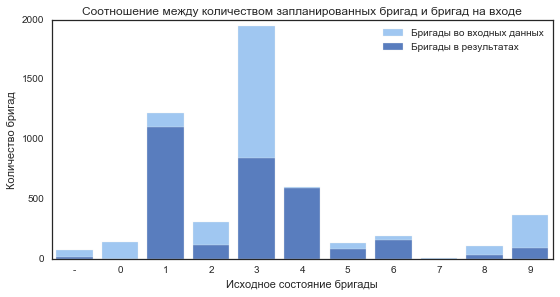

In [390]:
team_assigned_n = team_info[team_info.team.isin(team_plan[team_plan.state.isin([0, 1])].team)]\
                    .drop_duplicates('team').team.count()
team_total_n = team_info.drop_duplicates('team').team.count()
team_assigned_percent = team_assigned_n / team_total_n
add_line('Всего бригад, запланированных с локомотивами в работе: %d из %d (%.2f%%)' %
      (team_assigned_n, team_total_n, 100 * team_assigned_percent))
team_info['is_assign'] = team_info.team.isin(team_plan[team_plan.state.isin([0, 1])].team)
assign_states = team_info.loc[team_info.is_assign == True, ['team', 'state']].state.astype(str).value_counts().to_frame()
initial_states = team_info.state.value_counts().to_frame()
initial_states.columns=['Бригады во входных данных']
assign_states.columns=['Бригады в результатах']
states = initial_states.join(assign_states)
states.fillna(0, inplace=True)

sns.set(style='white', context='notebook')
sns.set_color_codes('pastel')
fig = plt.figure(figsize=(8, 4))
sns.barplot(x='index', y='Бригады во входных данных', data=states.sort_index().reset_index(), 
            color="b", label='Бригады во входных данных')
sns.set_color_codes('muted')
ax = sns.barplot(x='index', y='Бригады в результатах', data=states.sort_index().reset_index(), 
            color="b", label='Бригады в результатах')
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(ylabel='Количество бригад', xlabel='Исходное состояние бригады', 
       title='Соотношение между количеством запланированных бригад и бригад на входе')
#sns.despine()
filename = 'team_usage.png'
plt.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='real_fake'></a>
### Распределение реальных и фейковых бригад в результатах планирования

In [391]:
add_header('Распределение реальных и фейковых бригад в результатах планирования', h=2, p=False)

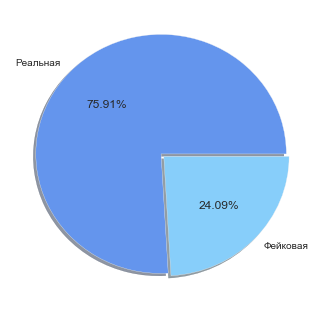

In [392]:
f = team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').team_type.value_counts()
fig = plt.figure(figsize=(5,5))
colors = ['cornflowerblue', 'lightskyblue']
expl = (0.03, 0) if len(f) == 2 else None
plt.pie(f, autopct='%.2f%%', colors=colors, explode=expl, shadow=True, labels=list(f.index))
filename = 'real_fake_teams_ratio.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='no_assign'></a>
## Cтанции и участки, на которых не состоялась подвязка бригады [ToC](#toc)

In [393]:
add_header('Станции и участки, на которых не состоялась подвязка бригады', h=2, p=False)

In [394]:
horizon = 6 * 3600
add_line('Горизонт анализа: %d часов' % (horizon / 3600), p=False)
loco_mask = (loco_plan.time_start < current_time + horizon)

In [395]:
# Добавляем признак первой станции на маршруте локомотива, где не была подвязана бригада
loco_plan.loc[loco_plan.state == 4, 'team'] = 0
loco_plan['no_team_start'] = (loco_plan.team == -1) & \
                             ((loco_plan.team != loco_plan.team.shift(1)) | (loco_plan.loco != loco_plan.loco.shift(1)))
    
loco_cols = ['loco', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'team', 'no_team_start']
fail_team_assign_locos = loco_plan.loc[loco_mask & (loco_plan.no_team_start == True)]
fail_team_assign_stations = fail_team_assign_locos.st_from_name.value_counts().head(10)
fail_team_assign_tracks = fail_team_assign_locos.groupby('st_from_name').st_to_name.value_counts().\
                            sort_values(ascending=False).head(10)
add_header('Станции, на которых не удалось подвязать бригады под локомотив (первые 10):')
add_line(fail_team_assign_stations)
add_header('\nУчастки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):')
add_line(fail_team_assign_tracks)

Станции, на которых не удалось подвязать бригады под локомотив (первые 10):
КРАСНОЯРСК-ВОСТОЧНЫЙ                  17
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ    10
АБАКАН                                 5
МЫСОВАЯ                                3
БЕЛОГОРСК II                           2
НОВЫЙ УРГАЛ                            2
УССУРИЙСК                              2
УЯР                                    2
ЗАОЗЕРНАЯ                              2
КАРЫМСКАЯ                              2

Участки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):
st_from_name                        st_to_name          
КРАСНОЯРСК-ВОСТОЧНЫЙ                ЗЫКОВО                  17
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  МЫЛКИ                    7
АБАКАН                              ТАШЕБА                   5
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  КОМСОМОЛЬСК-НА-АМУРЕ     3
БЕЛОГОРСК II                        БЕЛОГОРСК                2
НОВЫЙ УРГАЛ                         УРГАЛ I         

In [396]:
st_name = fail_team_assign_stations.head(1).index[0]
#st_name = 'КРАСНОЯРСК-ВОСТОЧНЫЙ'
bad_locos = loco_plan.loc[loco_mask & (loco_plan.st_from_name == st_name) & (loco_plan.no_team_start == True)]
if not bad_locos.empty:
    add_header('Локомотивы, к которым не была подвязана бригада на станции %s, по направлениям:' % st_name)
    add_line(bad_locos.st_to_name.value_counts())

Локомотивы, к которым не была подвязана бригада на станции КРАСНОЯРСК-ВОСТОЧНЫЙ, по направлениям:
ЗЫКОВО    17


<a id='overwork'></a>
## Проверка переработки бригад [ToC](#toc)

In [397]:
add_header('Бригады с переработкой', h=2, p=False)

#### Вычисляем последнее время явки для каждого участка на маршруте

In [398]:
# В поле presence прописываем последнюю явку бригады из входных данных
team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: max(x))
team_info['presence_norm'] = team_info.presence.apply(nice_time)
team_plan['info_presence'] = team_plan.team.map(team_info.set_index('team').presence)
team_plan['info_presence_norm'] = team_plan.info_presence.apply(nice_time)
team_plan['info_presence'] = team_plan.info_presence.apply(lambda x: [] if np.isnan(x) else [int(x)])

# Собираем все запланированные явки бригады. 
# Если ни одной явки не запланировано, то проставляем фейковые явки: время первого отправления (после отдыха) минус 1 час
team_plan['start_trip'] = team_plan.state.isin([0, 1]) \
                & ((team_plan.team != team_plan.team.shift(1)) | (team_plan.state.shift(1) == 4))
team_plan['fake_plan_presence'] = team_plan.team.map(team_plan[team_plan.start_trip].groupby('team').time_start.unique() - 3600)
team_plan.fake_plan_presence.fillna(0, inplace=True)
team_plan['fake_plan_presence'] = team_plan.fake_plan_presence.apply(lambda x: [] if (type(x) == int) else x)
team_plan['plan_presence'] = team_plan.team.map(team_plan[team_plan.state == 2].groupby('team').time_start.unique())
team_plan.plan_presence.fillna(0, inplace=True)
team_plan['plan_presence'] = team_plan.plan_presence.apply(lambda x: [] if (type(x) == int) else x)

In [399]:
def get_curr_presence(row):
    real_presence = np.concatenate([row.info_presence, row.plan_presence])   
    if len(real_presence) > 0:
        presence_list = real_presence
    elif len(row.fake_plan_presence) > 0:
        presence_list = row.fake_plan_presence
    else:
        return current_time
        
    t = row.time_start
    b = [x for x in presence_list if x <= t]
    return int(max(b)) if b != [] else (row.fake_plan_presence[0] if len(row.fake_plan_presence) > 0 else current_time)   
    
    
team_plan['curr_presence'] = team_plan.apply(lambda row: get_curr_presence(row), axis=1)
#cols = ['team', 'st_from_name', 'time_start', 'state', 'info_presence', 'info_presence_norm', 
#        'plan_presence', 'fake_plan_presence', 'curr_presence']
#team_plan[team_plan.team == '777700001868'][cols]

#### Составляем таблицу team_trips с поездками бригад

In [400]:
cols = ['team', 'state', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'loco', 'start_trip', 'end_trip', 
        'start_trip_time', 'end_trip_time']
team_plan['end_trip'] = ((team_plan.team != team_plan.team.shift(-1)) & (team_plan.state == 1)) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(-1).isin([0, 2, 4])))
team_plan.loc[team_plan.end_trip == True, 'end_trip_time'] = team_plan.time_end
team_plan['start_trip'] = ((team_plan.state == 1) & (team_plan.team != team_plan.team.shift(1))) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(1).isin([0, 2, 4])))
team_plan.loc[team_plan.start_trip == True, 'start_trip_time'] = team_plan.time_start
start_trips = team_plan.dropna(subset=['start_trip_time'])
end_trips = team_plan.dropna(subset=['end_trip_time'])

frames = [start_trips.reset_index()[['team', 'state', 'st_from_name', 'start_trip_time']],
          end_trips.reset_index()[['st_to_name', 'end_trip_time', 'curr_presence']]]
team_trips = pd.concat(frames, axis=1, ignore_index=True)
team_trips.columns = ['team', 'state', 'st_from_name', 'time_start', 'st_to_name', 'time_end', 'curr_presence']
add_info(team_trips)
team_trips['curr_presence_norm'] = team_trips.curr_presence.apply(nice_time)

In [401]:
team_trips[team_trips.team == '777700001868']

,team,state,st_from_name,time_start,st_to_name,time_end,curr_presence,time_start_f,time_end_f,curr_presence_norm


#### Загружаем нормы рабочего времени и составляем таблицу по нормам для каждой бригады

In [402]:
WORK_TIME_LIMIT = 11 #hours

In [403]:
def get_cmp(row):
    d, l = row.depot, row.link    
    try:
        res = trd.ix[d].link.apply(lambda x: len(np.intersect1d(x, l))).idxmax()        
    except:
        res = -1
    return res

team_region = pd.read_csv(FOLDER + 'team_region.csv', dtype={'st_from':str, 'st_to':str, 'depot':str})
add_info(team_region)
team_region['link'] = list(zip(team_region.st_from, team_region.st_to))
team_plan['link'] = list(zip(team_plan.st_from, team_plan.st_to))
tr_links = team_region.groupby(['team_region', 'depot']).link.unique().to_frame().reset_index()
if not tr_links.empty:
    trd = tr_links.set_index(['depot', 'team_region'])
else:
    trd = tr_links
team_links = team_plan[team_plan.state.isin([0, 1])].groupby(['team', 'depot']).link.unique().to_frame().reset_index()
team_links['team_region'] = team_links.apply(lambda row: get_cmp(row), axis=1)

team_links['tr_depot'] = list(zip(team_links.team_region, team_links.depot))
team_region['tr_depot'] = list(zip(team_region.team_region, team_region.depot))
team_links['time_f'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_f)
team_links['time_b'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_b)
team_links['time_wr'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_wr)
#team_links.head()

In [404]:
time_limit = team_links[['team', 'time_f', 'time_b', 'time_wr']]
time_limit.head()

,team,time_f,time_b,time_wr
0,200020920263,NaN,NaN,NaN
1,200020972738,NaN,NaN,NaN
2,200022946676,NaN,NaN,NaN
3,200023308269,NaN,NaN,NaN
4,200023315366,NaN,NaN,NaN


#### Вычисляем переработки, предварительно удалив выбросы

In [405]:
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'curr_presence_norm']
outliers = team_trips[team_trips.curr_presence < current_time - 24 * 3600]
#outliers = team_trips[team_trips.info_presence < current_time - 24 * 3600]
outliers_n = outliers.team.count()
add_header('Всего %d бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:' % outliers_n)
add_line(outliers.sort_values('curr_presence_norm').head(10 if outliers_n > 20 else outliers_n)[cols])

Всего 4 бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:
         team          st_from_name               st_to_name   time_start_f     time_end_f curr_presence_norm
 200200204240                   УЯР     КРАСНОЯРСК-ВОСТОЧНЫЙ  Aug 11, 02:06  Aug 11, 04:07      Aug 10, 15:30
 200200124079  КРАСНОЯРСК-ВОСТОЧНЫЙ                  БАЗАИХА  Aug 11, 20:27  Aug 11, 20:36      Aug 10, 16:55
 200200067275                ЭВОРОН  КОМСОМОЛЬСК-НА-АМУРЕ II  Aug 11, 00:13  Aug 11, 04:11      Aug 10, 18:00
 200200177534                МОГЗОН                   ЧИТА I  Aug 10, 23:40  Aug 11, 03:00      Aug 10, 19:10


In [406]:
pd.set_option('display.max_colwidth', 25)
# Оставляем только корректные бригады
team_trips = team_trips[(team_trips.team.isin(outliers.team) == False) & (team_trips.time_start < current_time + 24 * 3600)]
team_trips['time_limit'] = team_trips.team.map(time_limit.set_index('team').time_f)
team_trips['time_limit_no_rest'] = team_trips.team.map(time_limit.set_index('team').time_wr)
team_trips.time_limit.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips.time_limit_no_rest.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips[['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'time_limit', 'time_limit_no_rest']].head()

,team,st_from_name,st_to_name,curr_presence_norm,time_start_f,time_end_f,time_limit,time_limit_no_rest
0,200200105777,ИРКУТСК-СОРТИРОВОЧНЫЙ,ИРКУТСК-СОРТИРОВОЧНЫЙ,"Aug 11, 22:06","Aug 12, 00:00","Aug 12, 07:31",39600,39600
1,200200136379,ЧИТА I,ХИЛОК,"Aug 11, 23:00","Aug 12, 00:20","Aug 12, 05:51",39600,39600
2,200200251210,ОБЛУЧЬЕ,БЕЛОГОРСК II,"Aug 12, 01:49","Aug 12, 02:30","Aug 12, 10:11",39600,39600
3,200200189005,ИЛАНСКАЯ,ЗАОЗЕРНАЯ,"Aug 11, 14:30","Aug 11, 15:04","Aug 11, 20:45",39600,39600
4,200200216494,ЗИЛОВО,ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ,"Aug 11, 11:10","Aug 11, 17:20","Aug 11, 18:54",39600,39600


In [407]:
team_trips['work_time'] = np.round(((team_trips.time_end - team_trips.curr_presence) / 3600), 2)
#team_trips['overtime'] = team_trips.work_time.apply(lambda x: np.max([x - WORK_TIME_LIMIT, 0]))
team_trips['overtime'] = np.round((team_trips.time_end - team_trips.curr_presence - team_trips.time_limit) / 3600, 2)
team_trips['overtime'] = team_trips.overtime.apply(lambda x: 0 if x < 0 else x)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_end_f', 'overtime' ]
add_header('Количество бригад с переработкой (показаны первые 10 интервалов):')
add_line(pd.cut(team_trips.overtime, bins=np.arange(int(team_trips.overtime.max()) + 2), include_lowest=False)\
      .value_counts().head(10).sort_index())

Количество бригад с переработкой (показаны первые 10 интервалов):
(0, 1]      102
(1, 2]       49
(2, 3]       41
(3, 4]       14
(4, 5]       13
(5, 6]       17
(6, 7]       12
(7, 8]        8
(8, 9]        4
(13, 14]      4


In [408]:
pd.set_option('display.max_colwidth', 25)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'overtime' ]
add_header('\nБригады с переработкой больше 2 часов (всего %d):' % len(team_trips.loc[team_trips.overtime > 2].index))
add_line(team_trips.loc[team_trips.overtime > 2, cols].sort_values('overtime', ascending=False).head(20))

add_header('\nРаспределение бригад с переработкой больше 2 часов по типу:')
team_trips['team_type'] = team_trips.team.map(team_plan.drop_duplicates('team').set_index('team').team_type)
add_line(team_trips.loc[team_trips.overtime > 2].team_type.value_counts())


Бригады с переработкой больше 2 часов (всего 135):
         team              st_from_name       st_to_name curr_presence_norm   time_start_f     time_end_f  overtime
 777700021282                    АРХАРА           АРХАРА      Aug 12, 16:50  Aug 12, 17:50  Aug 14, 07:05     27.26
 777700021205                    ЧИТА I           ЧИТА I      Aug 12, 18:10  Aug 12, 19:10  Aug 14, 02:21     21.19
 200200178909                  ИЛАНСКАЯ         ИЛАНСКАЯ      Aug 11, 00:40  Aug 11, 20:50  Aug 12, 07:06     19.44
 777700021204                    ЧИТА I           ЧИТА I      Aug 12, 17:20  Aug 12, 18:20  Aug 13, 23:39     19.33
 200200151763                  УЛАН-УДЭ       СЛЮДЯНКА I      Aug 10, 21:40  Aug 11, 20:15  Aug 12, 01:43     17.05
 777700021284               СКОВОРОДИНО      СКОВОРОДИНО      Aug 12, 16:40  Aug 12, 17:40  Aug 13, 20:14     16.58
 200200198193  КОМСОМОЛЬСК-НА-АМУРЕ-...     ВЫСОКОГОРНАЯ      Aug 11, 06:36  Aug 12, 00:50  Aug 12, 09:58     16.37
 200200138998      К

In [409]:
team_ids = team_trips.loc[team_trips.overtime > 2].sort_values('overtime', ascending=False).team.values[:3]
#team_id = '777700001868'
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'time_end_f', 'loco']
team_info['depot_time_f'] = team_info.depot_time.apply(nice_time)
team_info['return_time_f'] = team_info.return_time.apply(nice_time)
team_info['depot_st_name'] = team_info.depot_st.map(st_names.name)
add_header('Примеры планов бригад с переработками:')
for team_id in team_ids:
    add_line('Бригада %s:' % team_id)
    add_line(team_info[team_info.team == team_id][['team', 'depot_st_name', 'depot_time_f', 'return_time_f', 'state', 'loco', 'loc_name']])
    add_line(team_plan[team_plan.team == team_id][cols])
    add_line('')

Примеры планов бригад с переработками:
Бригада 777700021282:
Empty DataFrame
Columns: [team, depot_st_name, depot_time_f, return_time_f, state, loco, loc_name]
Index: []
         team  st_from_name    st_to_name  state   time_start_f     time_end_f          loco
 777700021282        АРХАРА         БУРЕЯ      1  Aug 12, 17:50  Aug 12, 18:42  200200035690
 777700021282         БУРЕЯ       ЗАВИТАЯ      1  Aug 12, 18:42  Aug 12, 19:34  200200035690
 777700021282       ЗАВИТАЯ  БЕЛОГОРСК II      1  Aug 12, 19:34  Aug 12, 21:31  200200035690
 777700021282  БЕЛОГОРСК II       ЗАВИТАЯ      1  Aug 14, 02:51  Aug 14, 05:07  200200104062
 777700021282       ЗАВИТАЯ         БУРЕЯ      1  Aug 14, 05:07  Aug 14, 05:57  200200104062
 777700021282         БУРЕЯ        АРХАРА      1  Aug 14, 05:57  Aug 14, 07:05  200200104062

Бригада 777700021205:
Empty DataFrame
Columns: [team, depot_st_name, depot_time_f, return_time_f, state, loco, loc_name]
Index: []
         team st_from_name st_to_name  state   

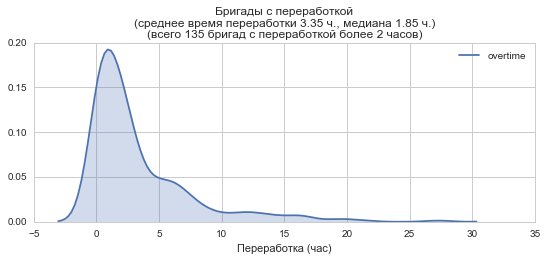

In [410]:
fig = plt.figure(figsize=(8, 3))
sns.set(style='whitegrid', context='notebook')
to_hist = team_trips.loc[team_trips.overtime > 0].overtime
sns.kdeplot(to_hist, shade=True)
title = '''Бригады с переработкой
(среднее время переработки %.2f ч., медиана %.2f ч.)
(всего %d бригад с переработкой более 2 часов)''' % \
            (to_hist.mean(), to_hist.median(), len(team_trips.loc[team_trips.overtime > 2].index))
plt.title(title)
plt.xlabel('Переработка (час)')
filename = 'team_overwork.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='leaps'></a>
## Скачки по станциям на маршруте бригад [ToC](#toc)

In [411]:
add_header('Скачки по станциям на маршруте бригад', h=2, p=False)

### Скачки внутри планируемого маршрута бригад

In [412]:
pd.set_option('display.max_colwidth', 20)
team_cols = ['team', 'st_from_name', 'st_to_name', 'next_st', 'time_start_f', 'time_end_f', 'state', 'state_info']
team_plan['is_end'] = team_plan.team != team_plan.team.shift(-1)
team_plan['next_st'] = team_plan.st_from_name.shift(-1)
team_leaps = team_plan.loc[(team_plan.is_end == False) 
                           & (team_plan.st_to_name != team_plan.next_st)
                           & (team_plan.st_to_name.notnull())
                           & (team_plan.next_st.notnull()), team_cols]
team_leaps_n = len(team_leaps.team.drop_duplicates().index)
add_header('\nВсего бригад, у которых есть скачки на маршруте: %d' % team_leaps_n)
add_header('Всего скачков на маршруте бригад: %d (показаны первые 10):' % len(team_leaps.index))
add_line(team_leaps.head(20))

add_header('\nСтанции, на которых наблюдаются скачки (первые 5):')
add_line(team_leaps.st_to_name.value_counts().head())

# Пример маршрута такой бригады (подставить id из предыдущего вывода):
team_cols2 = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'state_info']
#team_id = '200200164017'
if not team_leaps.empty:
    team_id = team_leaps.iloc[0].team
    add_header('\nМаршрут бригады %s:' % team_id)
    add_line(team_plan.loc[team_plan.team == team_id, team_cols2])


Всего бригад, у которых есть скачки на маршруте: 1094
Всего скачков на маршруте бригад: 1145 (показаны первые 10):
         team         st_from_name           st_to_name              next_st   time_start_f     time_end_f  state state_info
 200200105777                 ЗИМА                 ЗИМА            СУХОВСКАЯ  Aug 11, 10:10  Aug 11, 10:50      2          6
 200200136379                ХИЛОК                ХИЛОК               ЧИТА I  Aug 11, 08:20  Aug 11, 09:28      2          9
 200200216494               МОГОЧА               МОГОЧА               ЗИЛОВО  Aug 11, 11:10  Aug 11, 12:09      2          1
 200200224208           НОВАЯ ЧАРА           НОВАЯ ЧАРА              ТАКСИМО  Aug 11, 13:00  Aug 11, 14:50      2          5
 200200216511  ИРКУТСК-СОРТИРОВ...  ИРКУТСК-СОРТИРОВ...            ГОНЧАРОВО  Aug 11, 15:45  Aug 11, 17:39      2          6
 200200127736         БЕЛОГОРСК II         БЕЛОГОРСК II            БЕЛОГОРСК  Aug 11, 17:00  Aug 11, 17:40      2          1
 20020025

### Скачки между станцией исходного местоположения и первой станцией планирования

In [413]:
team_info.loc[team_info.st_from != '-1', 'first_station'] = team_info.loc[team_info.st_from != '-1', 'st_from']
team_info.loc[team_info.st_from == '-1', 'first_station'] = team_info.loc[team_info.st_from == '-1', 'oper_location']
team_info.loc[team_info.st_to != '-1', 'next_station'] = team_info.loc[team_info.st_to != '-1', 'st_to']
team_info[['team', 'oper_location', 'st_from', 'first_station', 'next_station']]
team_plan['first_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').first_station)
team_plan['next_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').next_station)
team_plan['first_st_name'] = team_plan.first_station.map(st_names.name)
team_plan['next_st_name'] = team_plan.next_station.map(st_names.name)
team_starts = team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').copy(deep=True)
start_leaps = team_starts[((team_starts.first_station.isnull() == False) & (team_starts.st_from != team_starts.first_station)) | 
            ((team_starts.next_station.isnull() == False) & (team_starts.st_to != team_starts.next_station))]

In [414]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info']
first_st_leaps = team_starts[(team_starts.first_station.isnull() == False) & (team_starts.next_station.isnull())
                             & (team_starts.st_from != team_starts.first_station)]
add_header('Распределение скачков бригад по станциям местоположения (показаны первые 5):')
add_line(first_st_leaps.first_st_name.value_counts().head())
add_header('\nБригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):')
add_line(first_st_leaps[cols].head(10))

Распределение скачков бригад по станциям местоположения (показаны первые 5):
БЕЛОГОРСК                34
ВИХОРЕВКА                 7
ИРКУТСК-СОРТИРОВОЧНЫЙ     6
ХАБАРОВСК I               4
КАДАЛА                    4

Бригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):
         team     st_from_name   st_to_name          loco first_st_name next_st_name     loco_info
 200200251140  СУХОВСКАЯ-ЮЖНАЯ      АНГАРСК  200200100277     СУХОВСКАЯ          NaN            -1
 200200223980     ХАБАРОВСК II  ХАБАРОВСК I  200200043221   ХАБАРОВСК I          NaN            -1
 200200112329     БЕЛОГОРСК II    БЕЛОГОРСК  200200106870     БЕЛОГОРСК          NaN            -1
 200200260299     ХАБАРОВСК II  ХАБАРОВСК I  200200095328   ХАБАРОВСК I          NaN            -1
 200200233304     БЕЛОГОРСК II    БЕЛОГОРСК  200200089702     БЕЛОГОРСК          NaN            -1
 200200206875     БЕЛОГОРСК II      ЗАВИТАЯ  200200037813     БЕЛОГОРСК          NaN   

In [415]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info', 'train']
loco_info['train_number'] = loco_info.train.map(train_info.drop_duplicates('train').set_index('train').number)
team_starts['train'] = team_starts.loco_info.map(loco_info.drop_duplicates('loco').set_index('loco').train_number)
next_st_leaps = team_starts[(team_starts.next_station.isnull() == False) 
                            & (team_starts.st_to != team_starts.next_station)]
add_header('Распределение скачков бригад по станциям направления (показаны первые 5):')
add_line(next_st_leaps.next_st_name.value_counts())
add_header('\nБригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):')
add_line(next_st_leaps[cols].head(10))

Распределение скачков бригад по станциям направления (показаны первые 5):
ТИСИН    1

Бригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):
         team st_from_name st_to_name loco first_st_name next_st_name     loco_info  train
 200200241724        ТИСИН       УЖУР   -1          УЖУР        ТИСИН  200200046677   4707


<a id='stop_time'></a>
## Анализ времен стоянок локомотивов для смены бригады [ToC](#toc)

In [416]:
add_header('Анализ времен стоянок локомотивов для смены бригады', h=2, p=False)

#### Распределение времен стоянок для смены бригады

In [417]:
def to_map(df, col):
    return df.drop_duplicates(col).set_index(col)

train_plan['train_time'] = list(zip(train_plan.train, train_plan.time_start))
loco_plan['train_time'] = list(zip(loco_plan.train, loco_plan.time_start))
loco_plan['loco_time'] = list(zip(loco_plan.loco, loco_plan.time_start))
team_plan['loco_time'] = list(zip(team_plan.loco, team_plan.time_start))
loco_plan['team'] = loco_plan.loco_time.map(to_map(team_plan, 'loco_time').team)
train_plan['loco'] = train_plan.train_time.map(to_map(loco_plan, 'train_time').loco)
train_plan['team'] = train_plan.train_time.map(to_map(loco_plan, 'train_time').team)

In [418]:
train_plan['next_time_start'] = train_plan.time_start.shift(-1)
train_plan['n_time_start_f'] = train_plan['next_time_start'].apply(nice_time)
train_plan['stop_time'] = train_plan.time_start.shift(-1) - train_plan.time_end
train_plan['train_end'] = train_plan.train != train_plan.train.shift(-1)
train_plan['loco_end'] = train_plan.loco != train_plan.loco.shift(-1)
train_plan['team_end'] = train_plan.team != train_plan.team.shift(-1)

In [419]:
train_plan['stop_time_h'] = train_plan.stop_time / 3600
cols = ['train', 'st_from_name', 'st_to_name', 'time_end_f', 'n_time_start_f', 'stop_time_h', 'loco', 'team']
longs = train_plan[(train_plan.train_end == False) & (train_plan.loco_end == False) 
           & (train_plan.stop_time > 10 * 3600)][cols].sort_values('stop_time_h',ascending=False)
print(longs.train.count())

281


In [420]:
cols = ['train', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'loco', 'team']
train_plan[train_plan.train == longs.iloc[0].train][cols]

,train,st_from_name,st_to_name,time_start_f,time_end_f,loco,team
76924,200022924890,ЧИТА I,КАДАЛА,"Aug 11, 17:39","Aug 11, 17:55",200200095163,200200098705
76925,200022924890,КАДАЛА,ЛЕСНАЯ,"Aug 11, 17:55","Aug 11, 18:51",200200095163,200200098705
76926,200022924890,ЛЕСНАЯ,ТУРГУТУЙ,"Aug 11, 18:51","Aug 11, 19:36",200200095163,200200098705
76927,200022924890,ТУРГУТУЙ,МОГЗОН,"Aug 11, 19:36","Aug 11, 20:35",200200095163,200200098705
76928,200022924890,МОГЗОН,ХИЛОК,"Aug 11, 20:35","Aug 11, 22:56",200200095163,200200098705
76929,200022924890,ХИЛОК,ЖИПХЕГЕН,"Aug 12, 03:40","Aug 12, 04:11",200200095163,210207561001
76930,200022924890,ЖИПХЕГЕН,ПЕТРОВСКИЙ ЗАВОД,"Aug 12, 04:11","Aug 12, 06:30",200200095163,210207561001
76931,200022924890,ПЕТРОВСКИЙ ЗАВОД,КИЖА,"Aug 12, 06:30","Aug 12, 07:02",200200095163,210207561001
76932,200022924890,КИЖА,ГОРХОН,"Aug 12, 07:02","Aug 12, 07:19",200200095163,210207561001
76933,200022924890,ГОРХОН,ЧЕЛУТАЙ,"Aug 12, 07:19","Aug 12, 07:56",200200095163,210207561001


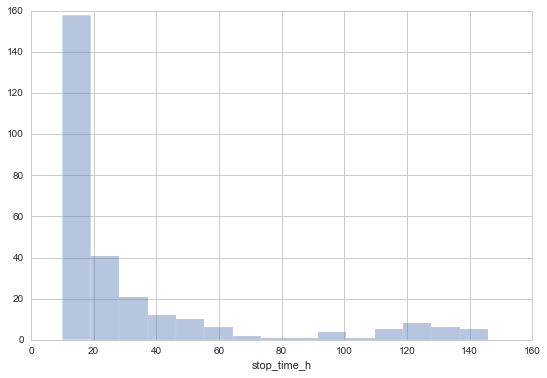

In [421]:
longs.stop_time_h.describe()
sns.distplot(longs.stop_time_h, kde=False, bins=15)
#plt.scatter(np.arange(len(longs.stop_time_h)), longs.stop_time_h)

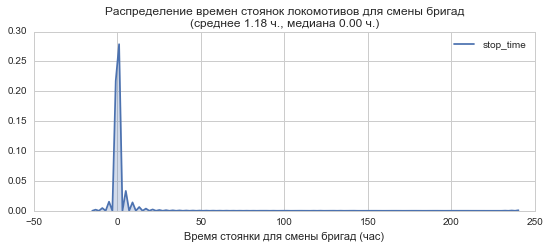

In [422]:
# Смена бригады без стоянки локомотива
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'team', 'time_start_next', 'loco_finish', 'stop_time']

loco_plan['team_start'] = (loco_plan.team != loco_plan.team.shift(1)) | (loco_plan.loco != loco_plan.loco.shift(1))
loco_plan['team_end'] = (loco_plan.team != loco_plan.team.shift(-1)) | (loco_plan.loco != loco_plan.loco.shift(-1))
start_teams = loco_plan.loc[(loco_plan.team.isin([-1, 0]) == False) & (loco_plan.team_start == True)].reset_index()\
                            [['loco', 'st_from_name', 'time_start', 'time_start_f', 'train', 'team']]
end_teams = loco_plan.loc[(loco_plan.team.isin([-1, 0]) == False) & (loco_plan.team_end == True)].reset_index()\
                            [['st_to_name', 'time_end', 'time_end_f']]
teams_trip = pd.concat([start_teams, end_teams], axis=1)
teams_trip['time_start_next'] = teams_trip.time_start.shift(-1)
teams_trip['loco_finish'] = teams_trip.loco != teams_trip.loco.shift(-1)
teams_trip.loc[teams_trip.loco_finish == False, 'stop_time'] = teams_trip.time_start_next - teams_trip.time_end
sns.set(style='whitegrid', context='notebook')
fig = plt.figure(figsize=(8, 3))
series_to_hist = teams_trip.dropna(subset=['stop_time']).stop_time / 3600
title = 'Распределение времен стоянок локомотивов для смены бригад\n(среднее %.2f ч., медиана %.2f ч.)' %\
        (series_to_hist.mean(), series_to_hist.median())
sns.kdeplot(series_to_hist, shade=True)
plt.title(title)
plt.xlabel('Время стоянки для смены бригад (час)')
filename = 'loco_stop_time.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Поиск локомотивов, у которых смены бригады занимает меньше 15 минут

In [423]:
#add_line('Время начала планирования' % time.ctime(current_time))
cols2 = ['loco', 'st_from_name', 'st_to_name', 'time_end_f', 'tsn_norm', 'train', 'stop_time', 'team']
pd.set_option('display.max_colwidth', 20)
teams_trip = teams_trip.dropna(subset=['time_start_next'])
teams_trip['tsn_norm'] = teams_trip.time_start_next.apply(nice_time)
teams_trip.loc[teams_trip.stop_time.isnull() == False, 'next_team'] = teams_trip.team.shift(-1)
teams_trip['train_type'] = teams_trip.train.apply(lambda x: 'Резерв' if str(x)[0]=='8' \
                                                      else ('Задания' if str(x)[0]=='9' else 'Реальный'))
fast_change = teams_trip.loc[teams_trip.stop_time < 15 * 60]
if fast_change.empty == False:
    add_header('Всего %d локомотивов со сменой бригад быстрее 15 минут (показаны первые 10):' % len(fast_change.index))
    add_line(fast_change[cols2].sort_values(['stop_time', 'loco']).head(10))
    add_header('\nРаспределение проблемных локомотивов по станциям смены (показаны первые 10 по частоте):')
    bad_st = fast_change.st_to_name.value_counts().to_frame().reset_index()
    bad_st.columns = ['station', 'freq']
    bad_st['norm_time'] = bad_st['station'].map(stations.drop_duplicates(subset=['name']).set_index('name').norm_time)
    add_line(bad_st.head(10))
    add_header('\nРаспределение проблемных локомотивов по типам поездов:')    
    add_line(fast_change.train_type.value_counts())
else:
    add_line('Нет локомотивов со сменой бригад со стоянкой меньше 15 минут')
    
# Посмотреть маршруты конкретных локомотивов или бригад
loco_cols = ['loco', 'st_from','st_to', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'team']
#team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
#print(loco_plan.loc[loco_plan.loco == '200200093307', loco_cols].to_string(index=False))
#print(team_plan.loc[team_plan.loco == '200250042559', team_cols].sort_values('time_start_norm').to_string(index=False))

Всего 25019 локомотивов со сменой бригад быстрее 15 минут (показаны первые 10):
         loco st_from_name   st_to_name     time_end_f       tsn_norm            train  stop_time team
 200200091433      ТАРСКАЯ    КАРЫМСКАЯ  Aug 14, 19:00  Aug 14, 03:59   88880018204425     -54057  NaN
 200200076468      ШКОТОВО  СМОЛЯНИНОВО  Aug 13, 22:58  Aug 13, 09:05     200021491039     -49970  NaN
 200200061048       ЗЫКОВО      БАЗАИХА  Aug 14, 07:48  Aug 13, 21:24  999928891032000     -37400  NaN
 200200103232        ТОРЕЯ       ТАЙШЕТ  Aug 14, 09:42  Aug 13, 23:36   88880018114553     -36391  NaN
 200200098655       ЗЫКОВО      БАЗАИХА  Aug 14, 05:48  Aug 13, 22:45  999928891012000     -25422  NaN
 200200092725   БАЙРОНОВКА       ТАЙШЕТ  Aug 14, 04:08  Aug 13, 21:56   88880018484473     -22278  NaN
 200200073760         ЮРТЫ       ТАЙШЕТ  Aug 14, 07:47  Aug 14, 02:24   88880018114546     -19374  NaN
 200200080910    УССУРИЙСК    УССУРИЙСК  Aug 14, 00:03  Aug 13, 19:00               -1     -1819

In [424]:
cols2 = ['loco', 'st_from_name', 'st_to_name', 'time_end_f', 'tsn_norm', 'train', 'stop_time', 'team']
long_change = teams_trip.loc[teams_trip.stop_time > 10 * 3600]
a = long_change.sort_values('stop_time', ascending=False)[cols2]
loco_id = a.iloc[0].loco
loco_plan[loco_plan.loco == loco_id][['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'train', 'team']]

,loco,st_from_name,st_to_name,time_start_f,time_end_f,train,team
24646,200200091211,СЛЮДЯНКА I,СЛЮДЯНКА II,"Aug 12, 02:20","Aug 12, 02:30",200024579297,200200210675
24647,200200091211,СЛЮДЯНКА II,АНГАСОЛКА,"Aug 12, 02:30","Aug 12, 02:56",200024579297,200200210675
24648,200200091211,АНГАСОЛКА,АНДРИАНОВСКАЯ,"Aug 12, 02:56","Aug 12, 03:10",200024579297,200200210675
24649,200200091211,АНДРИАНОВСКАЯ,БОЛЬШОЙ ЛУГ,"Aug 12, 03:10","Aug 12, 04:21",200024579297,200200210675
24650,200200091211,БОЛЬШОЙ ЛУГ,ГОНЧАРОВО,"Aug 12, 04:21","Aug 12, 04:39",200024579297,200200210675
24651,200200091211,ГОНЧАРОВО,КАЯ,"Aug 12, 04:39","Aug 12, 04:56",200024579297,200200210675
24652,200200091211,КАЯ,ИРКУТСК-ПАССАЖИР...,"Aug 12, 04:56","Aug 12, 05:08",200024579297,200200210675
24653,200200091211,ИРКУТСК-ПАССАЖИР...,ВОЕННЫЙ ГОРОДОК,"Aug 22, 05:15","Aug 22, 05:32",88880016774433,200200236527
24654,200200091211,ВОЕННЫЙ ГОРОДОК,ИРКУТСК-СОРТИРОВ...,"Aug 22, 05:32","Aug 22, 05:39",88880016774433,200200236527


<a id='rest_time'></a>
## Проверка времен отдыха бригад [ToC](#toc)

In [425]:
add_header('Проверка времен отдыха бригад', h=2, p=False)

In [426]:
add_line('Время начала планирования: %s' % nice_time(current_time))
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state', 'loco']
team_plan['time'] = np.round(((team_plan.time_end - team_plan.time_start) / 3600), 2)
rest_outliers = team_plan[(team_plan.state == 4) & (team_plan.time > 1000)]
add_header('Бригад с аномально большим временем отдыха: %d (показаны первые 10):' % len(rest_outliers.index))
out_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state']
if not rest_outliers.empty:
    add_line(rest_outliers[out_cols].head(10))

rest_check = team_plan[(team_plan.state == 4) & (team_plan.time < 1000)]

min_rest = rest_check.time.min()
if min_rest < 3:
    add_header('Минимальное время отдыха (3 часа) нарушено у %d бригад (показаны первые 10):' \
          % len(rest_check[rest_check.time < 3].index))
    add_line(rest_check[rest_check.time < 3][out_cols].head(10))    
else:
    add_header('Минимальное время отдыха бригад: %.2f часа' % (min_rest))

Время начала планирования: Aug 11, 19:31
Бригад с аномально большим временем отдыха: 0 (показаны первые 10):
Минимальное время отдыха (3 часа) нарушено у 6 бригад (показаны первые 10):
         team st_from_name st_to_name   time_start_f     time_end_f  time  state
 200200136227     МАРИИНСК   МАРИИНСК  Aug 11, 18:20  Aug 11, 19:31  1.19      4
 200200275329     МАРИИНСК   МАРИИНСК  Aug 11, 18:17  Aug 11, 19:31  1.24      4
 200200227445     МАРИИНСК   МАРИИНСК  Aug 11, 18:19  Aug 11, 19:31  1.21      4
 200200137210     МАРИИНСК   МАРИИНСК  Aug 11, 18:24  Aug 11, 19:31  1.13      4
 200200272926          NaN        NaN  Aug 11, 19:11  Aug 11, 19:31  0.34      4
 200200192690     МАРИИНСК   МАРИИНСК  Aug 11, 18:25  Aug 11, 19:31  1.11      4


#### Отсев бригад со слишком ранним временем явки

In [427]:
rest_old_presence = rest_check[(rest_check.info_presence < current_time - 12 * 3600) & (rest_check.state_info != '3')]
add_header('Всего %d бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:' 
           % rest_old_presence.team.count())
add_line(rest_old_presence.sort_values('time', ascending=False)[out_cols].head(10))

Всего 530 бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:
         team         st_from_name           st_to_name   time_start_f     time_end_f   time  state
 200200163633               РУЖИНО               РУЖИНО  Aug 11, 03:45  Aug 12, 17:25  37.67      4
 200200114238               РУЖИНО               РУЖИНО  Aug 11, 04:10  Aug 12, 17:25  37.25      4
 200200103714               РУЖИНО               РУЖИНО  Aug 11, 04:10  Aug 12, 17:25  37.25      4
 200200133562             САЯНСКАЯ             САЯНСКАЯ  Aug 11, 08:45  Aug 12, 14:44  29.98      4
 200200146085             САЯНСКАЯ             САЯНСКАЯ  Aug 11, 09:30  Aug 12, 14:44  29.23      4
 200200221189             САЯНСКАЯ             САЯНСКАЯ  Aug 11, 10:50  Aug 12, 14:44  27.90      4
 200200213346             САЯНСКАЯ             САЯНСКАЯ  Aug 11, 12:07  Aug 12, 14:44  26.62      4
 200200252334             САЯНСКАЯ             САЯНСКАЯ  Aug 11, 12:24  Aug 12, 14:44  26.33 

#### Бригады со слишком большим отдыхом

In [428]:
long_rest = rest_check[(rest_check.time > 10) & (rest_check.team.isin(rest_old_presence.team) == False)]
add_header('Всего %d бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):' % len(long_rest.index))
add_line(long_rest.sort_values('time', ascending=False)[out_cols].head(10))

Всего 66 бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):
         team         st_from_name           st_to_name   time_start_f     time_end_f   time  state
 200200191800            БАМБУРОВО            БАМБУРОВО  Aug 11, 19:34  Aug 12, 14:37  19.05      4
 200200252311          ВЕРХНЕЗЕЙСК          ВЕРХНЕЗЕЙСК  Aug 12, 09:43  Aug 13, 04:06  18.40      4
 200200268257             ГВОЗДЕВО             ГВОЗДЕВО  Aug 11, 19:30  Aug 12, 13:03  17.55      4
 200200277093                ТЫРМА                ТЫРМА  Aug 11, 14:00  Aug 12, 06:50  16.83      4
 200200164947             ГВОЗДЕВО             ГВОЗДЕВО  Aug 11, 20:47  Aug 12, 13:03  16.27      4
 200200162503        ГУСИНОЕ ОЗЕРО        ГУСИНОЕ ОЗЕРО  Aug 12, 08:30  Aug 13, 00:45  16.25      4
 200200279447             МАРГУЦЕК             МАРГУЦЕК  Aug 11, 21:30  Aug 12, 13:42  16.20      4
 200200111943  КРАСНОЯРСК-ВОСТО...  КРАСНОЯРСК-ВОСТО...  Aug 11, 18:57  Aug 12, 11:08  16.18      4
 200200210018     

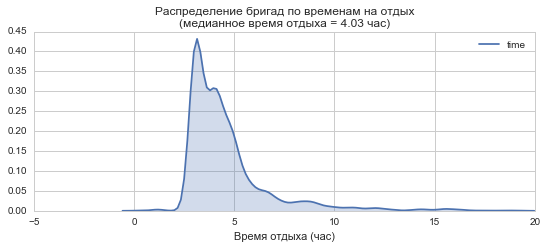

In [429]:
rest_show = rest_check[(rest_check.team.isin(rest_old_presence.team) == False)]
fig = plt.figure(figsize=(8, 3))
title = 'Распределение бригад по временам на отдых\n(медианное время отдыха = %.2f час)' % (rest_show.time.median())
sns.kdeplot(rest_show.time, shade=True)
plt.title(title)
plt.xlabel('Время отдыха (час)')
filename = 'team_rest_time.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Бригады с недостаточным отдыхом

In [430]:
rest = team_plan[team_plan.state == 4][['team', 'time_start', 'time']]
team_trips['rest_start_time'] = team_trips.team.map(rest.set_index('team').time_start)
team_trips['rest_start_time_f'] = team_trips.rest_start_time.apply(nice_time)
team_trips['rest_time'] = team_trips.team.map(rest.set_index('team').time)
team_trips['min_rest_time'] = np.round((team_trips.rest_start_time - team_trips.curr_presence) / (2 * 3600), 2)
team_trips['underrest'] = team_trips.min_rest_time - team_trips.rest_time

In [431]:
# Для подсчета требуемого отдыха удаляем поездки, которые связаны с одной явкой бригады; 
# для каждой явки оставляем только последнюю поездку, чтобы правильно взять полное рабочее время.
team_trips_cut = team_trips.sort_values(['team', 'curr_presence', 'work_time'], ascending=[True, True, False])\
                            .drop_duplicates(subset=['team', 'curr_presence'])

In [432]:
cols = ['team', 'curr_presence_norm', 'time_start_f', 'rest_start_time_f', 
        'work_time', 'min_rest_time', 'rest_time', 'underrest']
underrest = team_trips_cut[(team_trips_cut.time_start < team_trips_cut.rest_start_time) & (team_trips_cut.underrest > 0)]
underrest_n = underrest.team.drop_duplicates().count()
add_header('Всего %d бригад с недостаточным отдыхом:' % underrest_n)
add_header('Распределение по типу бригад:')
add_line(underrest.team_type.value_counts())

Всего 1188 бригад с недостаточным отдыхом:
Распределение по типу бригад:
Реальная    629
Фейковая    559


Всего 1094 бригад без переработки с недостаточным отдыхом.

Распределение по типу бригад:
Реальная    554
Фейковая    540

Примеры бригад без переработки с недостаточным отдыхом:
         team curr_presence_norm   time_start_f rest_start_time_f  work_time  min_rest_time  rest_time  underrest
 200200250648      Aug 11, 14:40  Aug 11, 19:55     Aug 12, 02:00      10.85           5.67       3.00       2.67
 200200279158      Aug 11, 14:25  Aug 11, 19:40     Aug 12, 01:36      10.70           5.60       3.00       2.60
 200200102883      Aug 11, 18:30  Aug 12, 00:50     Aug 12, 05:42      10.71           5.60       3.00       2.60
 200200212309      Aug 11, 17:50  Aug 11, 22:15     Aug 12, 04:51      10.52           5.51       3.05       2.46
 200200266635      Aug 11, 19:07  Aug 11, 23:20     Aug 12, 05:54      10.29           5.40       3.04       2.36
 200200201878      Aug 11, 19:10  Aug 11, 23:20     Aug 12, 06:34      10.91           5.71       3.37       2.34
 200200283333      Aug 

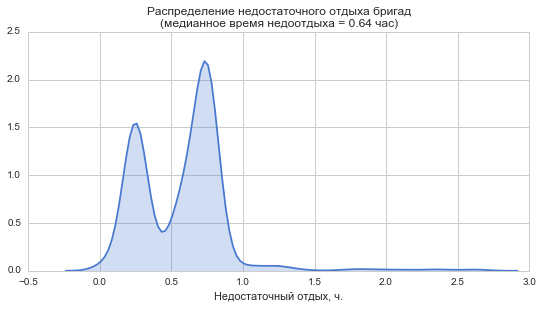

In [433]:
underrest_no_overtime = underrest[underrest.work_time <= WORK_TIME_LIMIT]
underrest_no_n = underrest_no_overtime.team.drop_duplicates().count()
add_header('Всего %d бригад без переработки с недостаточным отдыхом.' % underrest_no_n)
add_header('\nРаспределение по типу бригад:')
add_line(underrest_no_overtime.team_type.value_counts())
add_header('\nПримеры бригад без переработки с недостаточным отдыхом:')
add_line(underrest_no_overtime.sort_values('underrest', ascending=False)\
         .head(10 if underrest_no_n > 20 else underrest_no_n)[cols])

sns.set(style='whitegrid', context='notebook')
title = 'Распределение недостаточного отдыха бригад\n(медианное время недоотдыха = %.2f час)' \
            % (underrest_no_overtime.underrest.median())
fig = plt.figure(figsize=(8, 4))
ax = sns.distplot(underrest_no_overtime.underrest, color='b', hist=False, kde_kws={'shade':True})
ax.set(title=title, xlabel='Недостаточный отдых, ч.')
filename = 'team_under_rest.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [434]:
team_plan['loco_time'] = list(zip(team_plan.loco, team_plan.time_start))
loco_plan['loco_time'] = list(zip(loco_plan.loco, loco_plan.time_start))
team_plan['train'] = team_plan.loco_time.map(loco_plan.drop_duplicates('loco_time').set_index('loco_time').train)
#print(team_plan[team_plan.team == '777700000270']\
#      [['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 
#        'state', 'loco', 'train', 'time']].to_string(index=False))
time.ctime(1463065200)

'Thu May 12 18:00:00 2016'

## Проверка подвязки бригад по Иркутску

In [435]:
add_header('Анализ бригад, проезжающих через Иркутск', h=2, p=False)

In [436]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'depot_name']
team_plan['depot_name'] = team_plan.depot.map(st_names.name)
st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
train_cols = ['train', 'number', 'st_from_name', 'st_to_name', 'time_start_f']
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[:1])
add_header('Распределение поездов через Иркутск по направлениям:')
add_line(train_plan.loc[(train_plan.st_from_name == st_name)
              & (train_plan.time_start >= current_time) & (train_plan.train_type.isin(['2', '9']))
              & (train_plan.time_start < current_time + 24*3600), train_cols].st_to_name.value_counts())

add_header('\nРаспределение бригад, в маршруте которых есть Иркутск, по депо приписки:')
b = team_plan.loc[(team_plan.st_from_name == st_name) & (team_plan.state.isin([0, 1]))
              & (team_plan.time_start >= current_time), team_cols].groupby('depot_name').team.count().to_frame()
b['percent'] = np.round((100 * b.team / b.team.sum()), 2)
b['percent'] = b['percent'].apply(lambda x: str(x) + '%')
add_line(b.reset_index())

Распределение поездов через Иркутск по направлениям:
ГОНЧАРОВО     50
БАТАРЕЙНАЯ    46

Распределение бригад, в маршруте которых есть Иркутск, по депо приписки:
          depot_name  team percent
                ЗИМА    63  57.27%
 ИРКУТСК-СОРТИРОВ...    38  34.55%
         НИЖНЕУДИНСК     3   2.73%
          СЛЮДЯНКА I     1   0.91%
            УЛАН-УДЭ     5   4.55%


<a id='ready_time'></a>
## Проверка времени явки бригад [ToC](#toc)

In [437]:
add_header('Проверка корректости времен явки бригад в депо приписки во входных данных', h=2, p=False)

1. У бригад, которые находятся на домашнем отдыхе (state = 3) передается именно время ухода на отдых. По постановке (см. раздел "Заполнение атрибутов для входных сообщений по бригадам") должно передаваться время ухода на отдых + 16 часов.
2. Для бригады 200200158216 передается state=3, хотя по АСУ-Т последней операцией на 18.04 10:35 было "прибытие на станцию Лесовозный 17.04 в 08:49" (или, в крайнем случае, отправление с Улан-Удэ 17.04 в 07:51).
3. Аналогично для бригады 200200225600. Впрочем, возможно, это какой-то косяк АСУ-Т. В любом случае, пункт 1 - это очевидный баг.

Общая идея:
- если у бригад указано depot_time < rest_start_time, то эта разница не должна быть очень большой. 
- если у бригад указано depot_time < return_time, то эта разница тоже не должна быть очень большой.

In [438]:
add_line('Время начала планирования: %s' % (nice_time(current_time)))
team_info['dt_norm'] = team_info.depot_time.apply(nice_time)
team_info['rt_norm'] = team_info.return_time.apply(nice_time)
team_info['rst_norm'] = team_info.rest_time.apply(nice_time)
team_info['rest_dep_delta'] = np.round(((team_info.rest_time - team_info.depot_time) / 3600), 2)
team_info['return_dep_delta'] = np.round(((team_info.return_time - team_info.depot_time) / 3600), 2)

dep_less_rest = team_info[(team_info.depot_time < team_info.rest_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'rest_dep_delta', 'ready_type', 'state']
add_header('Всего %d бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:' 
          % dep_less_rest[dep_less_rest.rest_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_rest[dep_less_rest.rest_dep_delta > 12][info_cols].sort_values('rest_dep_delta', ascending=False).head(10))

dep_less_return = team_info[(team_info.depot_time < team_info.return_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'return_dep_delta', 'ready_type', 'state']
add_header('\nВсего %d бригад, у которых время последней явки в депо намного меньше (на 18+ часов) времени явки в пункте оборота. Примеры:' 
          % dep_less_return[dep_less_return.return_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_return[dep_less_return.return_dep_delta > 12][info_cols].sort_values('return_dep_delta', ascending=False).head(10))

Время начала планирования: Aug 11, 19:31
Всего 386 бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:
         team      number dt_norm       rst_norm  rest_dep_delta ready_type state
 200200153718  9601013312          Aug 11, 16:41       408589.68     return     4
 200200256173  9411017765          Aug 11, 06:17       408579.28     return     8
 200200244406  8805004127          Aug 11, 04:31       408577.52     return     8
 230204027608  9405068477          Aug 11, 03:40       408576.67     return     4
 200200144850  9411044402          Aug 11, 02:20       408575.33     return     0
 200200142453  9411002974          Aug 11, 01:10       408574.17     return     0
 200200222432  9414085278          Aug 11, 00:00       408573.00     return     7
 200218913232  9411095265          Aug 10, 19:47       408568.78     return     9
 200200155862  8805005437          Aug 10, 18:02       408567.03     return     9
 20020006

<a id='change'></a>
## Проверка смены бригад на корректных станциях [ToC](#toc)

In [439]:
add_header('Проверка смены бригад на корректных станциях', h=2, p=False)

### Проверка случаев проезда бригад мимо станций обязательной смены

In [440]:
add_header('Проверка проезда бригад мимо станций обязательной смены', h=3, p=False)

In [441]:
st_team_change_full = ['КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗИМА', 'ХИЛОК', 'МОГОЧА', 'ОБЛУЧЬЕ', 'РУЖИНО', 'СМОЛЯНИНОВО', 
                      'САЯНСКАЯ', 'ЛЕНА', 'СЕВЕРОБАЙКАЛЬСК', 'НОВЫЙ УОЯН', 
                      'НОВАЯ ЧАРА', 'ЮКТАЛИ', 'ВЕРХНЕЗЕЙСК', 'ФЕВРАЛЬСК', 'ПОСТЫШЕВО', 'ВЫСОКОГОРНАЯ', 
                      'УЖУР', 'ТЫРМА']
                 
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'loco_end', 'no_stop']
team_plan['loco_end'] = team_plan.loco != team_plan.loco.shift(-1)
team_plan['no_stop'] = team_plan.time_end == team_plan.time_start.shift(-1)
no_stop = team_plan[(team_plan.st_to_name.isin(st_team_change_full)) & (team_plan.state == 1) 
                    & (team_plan.loco_end == False) & (team_plan.no_stop == True)]
add_header('Всего %d случаев проезда бригад мимо станций обязательной смены' % len(no_stop.index))
add_header('\nРаспределение по станциям (первые 5 самых частых):')
add_line(no_stop.st_to_name.value_counts().head())

Всего 101 случаев проезда бригад мимо станций обязательной смены

Распределение по станциям (первые 5 самых частых):
ЗИМА          48
НОВЫЙ УОЯН    21
РУЖИНО        11
ОБЛУЧЬЕ        5
ХИЛОК          4


In [442]:
add_header('\nПримеры ошибочных бригад (первые 10):')
add_line(no_stop.drop_duplicates('st_to_name').sort_values('time_end')[cols])


Примеры ошибочных бригад (первые 10):
         team     st_from_name   st_to_name   time_start_f     time_end_f  state          loco loco_end no_stop
 200200223386          ПЕРЕВОЗ         ЗИМА  Aug 11, 19:14  Aug 11, 19:30      1  200200102416    False    True
 200200216432           ЯКУРИМ         ЛЕНА  Aug 11, 19:52  Aug 11, 20:06      1  200200029294    False    True
 200200245865           АРХАРА      ОБЛУЧЬЕ  Aug 11, 19:40  Aug 11, 21:59      1  200200090182    False    True
 200200197043      КСЕНЬЕВСКАЯ       МОГОЧА  Aug 11, 20:35  Aug 11, 22:56      1  200200087120    False    True
 200200097788  СЕВЕРОБАЙКАЛЬСК   НОВЫЙ УОЯН  Aug 11, 19:45  Aug 11, 23:16      1  200200044975    False    True
 777700019518       НОВОНЕЖИНО  СМОЛЯНИНОВО  Aug 12, 01:04  Aug 12, 01:29      1  200205819226    False    True
 777700020061         ЖИПХЕГЕН        ХИЛОК  Aug 12, 09:43  Aug 12, 10:16      1  200200105848    False    True
 777700019517         ШМАКОВКА       РУЖИНО  Aug 12, 11:27  Aug 1

In [443]:
add_header('Полные планы по некоторым ошибочным бригадам:')
top_st = no_stop.st_to_name.value_counts().index[0]
sec_st = no_stop.st_to_name.value_counts().index[1]
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
add_line(team_plan[team_plan.team == no_stop[no_stop.st_to_name == top_st].iloc[0].team][cols])
add_line('')
add_line(team_plan[team_plan.team == no_stop[no_stop.st_to_name == sec_st].iloc[0].team][cols])

Полные планы по некоторым ошибочным бригадам:
         team         st_from_name   st_to_name   time_start_f     time_end_f  state          loco
 200200223386          НИЖНЕУДИНСК  НИЖНЕУДИНСК  Aug 11, 14:00  Aug 11, 15:00      2            -1
 200200223386                ТУЛУН         АЗЕЙ  Aug 11, 16:58  Aug 11, 17:22      1  200200102416
 200200223386                 АЗЕЙ       КУЙТУН  Aug 11, 17:22  Aug 11, 18:23      1  200200102416
 200200223386               КУЙТУН      ПЕРЕВОЗ  Aug 11, 18:23  Aug 11, 19:14      1  200200102416
 200200223386              ПЕРЕВОЗ         ЗИМА  Aug 11, 19:14  Aug 11, 19:30      1  200200102416
 200200223386                 ЗИМА       ЗАЛАРИ  Aug 11, 19:30  Aug 11, 20:37      1  200200102416
 200200223386               ЗАЛАРИ    ЧЕРЕМХОВО  Aug 11, 20:37  Aug 11, 21:56      1  200200102416
 200200223386            ЧЕРЕМХОВО   КАСЬЯНОВКА  Aug 11, 21:56  Aug 11, 22:13      1  200200102416
 200200223386           КАСЬЯНОВКА       МАЛЬТА  Aug 11, 22:13 

#### Причины проезда бригад мимо станций смены:

1. Новый Уоян: у бригад в участках обкатки присутствует участок 2002118258 (Северобайкальск -- Таксимо). Возможное решение: проверить участки обкатки, выяснить, откуда берется участок обкатки Северобайкальск -- Таксимо, удалить этот участок при необходимости.

2. Зима. Фейковым бригадам хватает рабочего времени, чтобы доехать из Иркутска до Нижнеудинска (время хода --- чуть более 9 часов). Для этих бригад должен определяться УОЛБ 920502 "Иркутск -- Зима" с нормативным рабочим временем ровно 9 часов (540). Так что должна планироваться смена в Зиме. Возможные причины ошибки:
  1. Определяется другой УОЛБ - а именно, УОЛБ 920503 "Иркутск -- Гончарово, Кая -- Зима". У этого УОЛБ рабочее время = 600 (10 часов). 
  2. У фейковой бригады неверно указывается депо приписки (или не указывается вообще). Тогда для нее может вообще не быть найден УОЛБ.

### Проверка случаев смены бригад не на допустимых станциях

In [444]:
add_header('Проверка случаев смены бригад не на допустимых станциях', h=3, p=False)

In [445]:
add_line('Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда' + 
         ', а также случаи смены бригады на станции, которая является депо приписки бригады')

Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда, а также случаи смены бригады на станции, которая является депо приписки бригады


In [446]:
loco_plan['end_trip'] = (loco_plan.state != loco_plan.state.shift(-1)) | (loco_plan.train != loco_plan.train.shift(-1))\
                        | (loco_plan.loco != loco_plan.loco.shift(-1))
team_plan['start_station_name'] = team_plan.team.map(team_plan[team_plan.state.isin([0, 1])]\
                                                     .drop_duplicates('team').set_index('team').st_from_name)
team_plan.depot_name.fillna(team_plan.start_station_name, inplace=True)
team_plan['depot_st_name'] = team_plan.depot_st.map(st_names.name)
team_plan.depot_st_name.fillna(team_plan.start_station_name, inplace=True)
loco_plan['team_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_name)
loco_plan['team_ready_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_st_name)

In [447]:
pr_st = pd.read_csv(FOLDER + 'mandatory/priority_team_change_stations.csv', sep=';', encoding='utf-8-sig', dtype={'station':str}).station
team_change = loco_plan[(loco_plan.state != 4) & (loco_plan.team_end == True) & (loco_plan.end_trip == False)]
bad_team_change = team_change[(team_change.st_to.isin(pr_st) == False) 
                              & (team_change.st_to_name != team_change.team_depot_name)
                              & (team_change.st_to_name != team_change.team_ready_depot_name)]
if bad_team_change.st_to_name.dropna().empty:
    add_header('Все бригады меняются только на приоритетных станциях смены')
else:
    add_header('Всего %d случаев смены бригад не на приоритетных станциях смены (%.2f%%)'
              % (bad_team_change.loco.count(), 100 * bad_team_change.loco.count() / team_change.loco.count()))
    add_header('Распределение по неприоритетным станциям (первые 10):')
    add_line(bad_team_change.st_to_name.value_counts().head(10))   
    

Всего 23121 случаев смены бригад не на приоритетных станциях смены (77.43%)
Распределение по неприоритетным станциям (первые 10):
ЗЫКОВО        263
ТАРСКАЯ       254
УЯР           249
КАСЬЯНОВКА    246
МАЛЬТА        246
АНГАРСК       240
КИТОЙ         238
ЗАЛАРИ        238
БАТАРЕЙНАЯ    237
ЧЕРЕМХОВО     235


In [448]:
with (pd.option_context('display.max_colwidth', 20)):
    if not bad_team_change.st_to_name.dropna().empty:
        add_header('Примеры локомотивов и бригад, для которых смена указанной бригады произошла не на приоритетной станции:')
        add_line(bad_team_change[['loco', 'team', 'st_to_name', 'time_end_f', 'train']].head(10))
        cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'train', 'team', 'team_depot_name']        
        loco_id = bad_team_change[bad_team_change.st_to_name == bad_team_change.st_to_name.value_counts().idxmax()]\
                    .drop_duplicates('loco').iloc[0,:].loco
        add_header('Полный план по одному из таких локомотивов:')
        add_line(loco_plan[loco_plan.loco == loco_id][cols])

Примеры локомотивов и бригад, для которых смена указанной бригады произошла не на приоритетной станции:
         loco team       st_to_name     time_end_f         train
 200200085572  NaN          ЖИРЕКЕН  Aug 13, 03:01  200022952447
 200200085572  NaN           ЗИЛОВО  Aug 13, 03:52  200022952447
 200200085572  NaN      КСЕНЬЕВСКАЯ  Aug 13, 06:19  200022952447
 200200085572  NaN           АМАЗАР  Aug 13, 11:42  200022952447
 200200085572  NaN  ЕРОФЕЙ ПАВЛОВИЧ  Aug 13, 14:06  200022952447
 200200085572  NaN        БАМОВСКАЯ  Aug 13, 17:36  200022952447
 200200085572  NaN          ГОРЕЛЫЙ  Aug 13, 17:43  200022952447
 200200085572  NaN    БОЛЬШОЙ НЕВЕР  Aug 13, 19:33  200022952447
 200200085572  NaN           ТАЛДАН  Aug 13, 21:12  200022952447
 200200085572  NaN           УШУМУН  Aug 14, 02:20  200022952447
Полный план по одному из таких локомотивов:
         loco         st_from_name           st_to_name   time_start_f     time_end_f            train          team team_depot_name
 200

<a id='presence'></a>
## Проверка отправления бригады не ранее времени явки [ToC](#toc)

In [449]:
add_header('Проверка отправления бригады не ранее времени явки', h=2, p=False)

In [450]:
# Вычисляем максимальное время явки, добавляем его в team_info и team_plan
# В таблице presence_fail --- ошибочные отправления бригад до времени явки

presence_lim = 0
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'ready_type', 
             'presence_norm', 'presence_gap', 'state', 'state_info']

team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: x[0] if x[0] > x[1] else x[1])
team_info['presence_norm'] = team_info.presence.apply(nice_time)
team_plan['presence'] = team_plan.team.map(team_info.set_index('team').presence)
team_plan['presence_norm'] = team_plan.presence.apply(nice_time)
team_plan['presence_gap'] = team_plan.time_start - team_plan.presence
team_plan['ready_type'] = team_plan.team.map(team_info.set_index('team').ready_type)
presence_fail = team_plan[(team_plan.state.isin([0, 1])) & (team_plan.presence_gap < presence_lim)].drop_duplicates('team')
pr = team_info[['team', 'depot_time', 'return_time', 'presence', 'presence_norm']]

In [451]:
p = presence_fail[presence_fail.state == 0]
ph = presence_fail[(presence_fail.state == 0) & (presence_fail.time_start >= current_time)]
if not p.empty:
    add_header('Всего бригад, которые отправлены пассажиром ранее времени явки: %d (показаны первые 10)' % p.team.count())
    add_line(p.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки')
    
if not ph.empty:
    add_header('\nВсего бригад, которые отправлены пассажиром ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % ph.team.count())
    add_line(ph.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования')

Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки

Нет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования


In [452]:
f = presence_fail[presence_fail.state == 1]
fh = presence_fail[(presence_fail.state == 1) & (presence_fail.time_start >= current_time)]
if not f.empty:
    add_header('Всего бригад, которые отправлены с локомотивом ранее времени явки: %d (показаны первые 10)' % f.team.count())
    add_line(f.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки')

if not fh.team.empty:
    add_header('\nВсего бригад, которые отправлены с локомотивом ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % fh.team.count())
    add_line(fh.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования')

Всего бригад, которые отправлены с локомотивом ранее времени явки: 1 (показаны первые 10)
         team st_from_name st_to_name   time_start_f ready_type  presence_norm  presence_gap  state state_info
 200200196751    БЕСТУЖЕВО   БЕРКАКИТ  Aug 11, 01:27      depot  Aug 11, 14:00        -45180      1          1

Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования


<a id='before_current_time'></a>
## Проверка планирования бригад до времени начала планирования [ToC](#toc)

In [453]:
add_header('Проверка планирования бригад до времени начала планирования', h=2, p=False)

In [454]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'state_info']

add_line('(Не учитываются бригады, которые на начало планирования находились на перегоне)')
add_line('Время начала планирования: %s' % nice_time(current_time))

total_teams = team_plan.team.drop_duplicates().count()

tbef = team_plan[(team_plan.time_start < current_time)          
         & (team_plan.state.isin([0, 1])) & (team_plan.state_info != team_plan.state.apply(str))].drop_duplicates('team')
add_header('\nВсего бригад, отправленных до начала планирования: %d (%.2f%% от всех запланированных бригад)' 
           % (tbef.team.count(), 100 * tbef.team.count() / total_teams))
if not tbef.empty:
    add_header('\nРаспределение по состояниям бригад, отправленных до начала планирования:')
    add_line(tbef.state.value_counts())
    
    for i in sorted(tbef.state.unique()):
        add_header('\nБригады, отправленные до начала планирования в состоянии %d (первые 10):' % i)
        add_line(tbef[tbef.state == i].sort_values('time_start').head(10)[team_cols])

    add_header('\nРаспределение по типу бригад, отправленных до начала планирования в состоянии 1:')
    add_line(tbef[tbef.state == 1].team_type.value_counts())

(Не учитываются бригады, которые на начало планирования находились на перегоне)
Время начала планирования: Aug 11, 19:31

Всего бригад, отправленных до начала планирования: 0 (0.00% от всех запланированных бригад)


<a id='presenting'></a>
## Проверка планируемых явок бригад [ToC](#toc)

In [455]:
add_header('Проверка планируемых явок бригад', h=2, p=False)

Разброс времен на явку бригад: от 0.32 ч. до 5.90 ч.


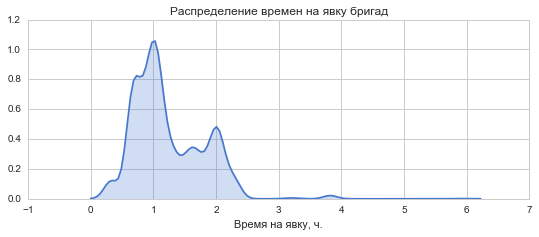

In [456]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'tt', 'state', 'loco', 'state_info']
team_plan['tt'] = team_plan.time_end - team_plan.time_start
min_presenting = team_plan[team_plan.state == 2][team_cols].tt.min()
max_presenting = team_plan[team_plan.state == 2][team_cols].tt.max()
add_header('Разброс времен на явку бригад: от %.2f ч. до %.2f ч.' % (min_presenting / 3600, max_presenting / 3600))

sns.set(style='whitegrid', context='notebook')
fig = plt.figure(figsize=(8, 3))
ax = sns.distplot(team_plan[team_plan.state == 2][team_cols].tt / 3600, hist=False, bins=20, color='b', kde_kws={'shade':True})
ax.set(xlabel='Время на явку, ч.', title='Распределение времен на явку бригад')
filename = 'team_presenting.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [457]:
team_plan['next_state'] = team_plan.state.shift(-1)
team_plan['next_time_start_f'] = team_plan.time_start_f.shift(-1)
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'next_state', 'time_start_f', 'time_end_f', 'next_time_start_f']
rest_pres = team_plan[(team_plan.team == team_plan.team.shift(-1)) 
                     & (team_plan.state == 4) & (team_plan.next_state == 2)
                     & (team_plan.time_end_f != team_plan.next_time_start_f)]
add_header('Всего %d бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):' 
      % rest_pres.team.drop_duplicates().count())
add_line(rest_pres[rest_pres.time_start >= current_time].sort_values('time_start').head(10)[cols])
add_header('\nРаспределение таких ошибочных явок после отдыха по станциям (показаны первые 5):')
add_line(rest_pres.st_from_name.value_counts().head())

Всего 1475 бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):
         team         st_from_name           st_to_name  state  next_state   time_start_f     time_end_f next_time_start_f
 200200088351             УЛАН-УДЭ             УЛАН-УДЭ      4           2  Aug 11, 19:31  Aug 11, 23:12     Aug 11, 23:58
 200200169113                 ЗИМА                 ЗИМА      4           2  Aug 11, 19:35  Aug 11, 22:48     Aug 11, 23:49
 200200282368                УРУША                УРУША      4           2  Aug 11, 19:36  Aug 11, 22:36     Aug 12, 04:39
 200200266809             УЛАН-УДЭ             УЛАН-УДЭ      4           2  Aug 11, 19:40  Aug 11, 22:40     Aug 12, 00:23
 200200266231          КОШУРНИКОВО          КОШУРНИКОВО      4           2  Aug 11, 19:42  Aug 11, 22:42     Aug 11, 23:59
 200200212284            БЕЛОГОРСК            БЕЛОГОРСК      4           2  Aug 11, 19:42  Aug 11, 22:42     Aug 12, 00:07
 200200067559                 ЗИМА 

<a id='check_useful_assign'></a>
## Проверка использования бригад [ToC](#toc)

In [458]:
add_header('Проверка использования бригад', h=2, p=False)

<a id='only_pass'></a>
### Бригады, запланированные к отправлению пассажирами без последующей подвязки [ToC](#toc)

In [459]:
add_header('Проверка использования бригад после засылки пассажирами', h=3, p=False)

In [460]:
team_plan['all_states'] = team_plan.team.map(team_plan.groupby('team').state.unique())
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'depot_name',
        'state', 'all_states']

In [461]:
def get_cat(all_states):
    if 1 in all_states:
        return 'work'
    elif (len(all_states) == 1) & (all_states[0] == 2):
        return 'only_presence'
    elif (len(all_states) == 2):
        if ((all_states[0] == 4) & (all_states[1] == 0)):
            return 'pass_home'
        else:
            return 'fail'
    elif (len(all_states) == 3):
        if all([2, 4, 0] == all_states):
            return 'pass_home'
        else:
            return 'fail'
    else:
        return 'fail'

team_plan['cat'] = team_plan.all_states.apply(get_cat)
only_pass_teams = team_plan[(team_plan.cat == 'fail') & (team_plan.state_info != '2')]
                            
add_header('Всего %d бригад, для которых планируется отправка пассажиром и не планируется работа с поездом' 
      % only_pass_teams.team.drop_duplicates().count())

Всего 15 бригад, для которых планируется отправка пассажиром и не планируется работа с поездом


In [462]:
add_header('Станции, с которых чаще всегда планируется лишняя отправка пассажирами:')
add_line(only_pass_teams.drop_duplicates('team').st_from_name.value_counts().head(10))

Станции, с которых чаще всегда планируется лишняя отправка пассажирами:
ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ    3
ОБЛУЧЬЕ                     1
ЕРОФЕЙ ПАВЛОВИЧ             1
ТЫНДА                       1
СМОЛЯНИНОВО                 1
ИРКУТСК-СОРТИРОВОЧНЫЙ       1
СЕВЕРОБАЙКАЛЬСК             1
АЧИНСК I                    1


In [463]:
with pd.option_context('display.max_colwidth', 25):
    if only_pass_teams.team.drop_duplicates().count() != 0:
        add_header('Примеры:')
        for team in only_pass_teams.team.drop_duplicates().iloc[:3].values:    
            add_line(team_plan[team_plan.team == team][cols])
            add_line('')

Примеры:
         team st_from_name st_to_name   time_start_f     time_end_f depot_name  state all_states
 200200136227          NaN        NaN  Aug 11, 09:20  Aug 11, 10:20        NaN      2     [2, 4]
 200200136227     МАРИИНСК   МАРИИНСК  Aug 11, 18:20  Aug 11, 19:31        NaN      4     [2, 4]

         team st_from_name st_to_name   time_start_f     time_end_f depot_name  state all_states
 200200163497     АЧИНСК I   АЧИНСК I  Aug 11, 17:50  Aug 11, 23:45   АЧИНСК I      4        [4]

         team st_from_name st_to_name   time_start_f     time_end_f depot_name  state all_states
 200200104150      ОБЛУЧЬЕ    ОБЛУЧЬЕ  Aug 11, 17:25  Aug 11, 23:31    ОБЛУЧЬЕ      4        [4]



In [464]:
irk = only_pass_teams[only_pass_teams.st_from_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ']
if not irk.empty:
    add_header('Пример бесцельной отправки пассажиром со станции Иркутск-Сортировочный:')
    add_line(team_plan[team_plan.team == irk.iloc[0].team][cols])

Пример бесцельной отправки пассажиром со станции Иркутск-Сортировочный:
         team         st_from_name           st_to_name   time_start_f     time_end_f           depot_name  state all_states
 200200132628  ИРКУТСК-СОРТИРОВ...  ИРКУТСК-СОРТИРОВ...  Aug 11, 09:30  Aug 11, 11:24  ИРКУТСК-СОРТИРОВ...      2     [2, 4]
 200200132628  ИРКУТСК-СОРТИРОВ...  ИРКУТСК-СОРТИРОВ...  Aug 11, 20:05  Aug 11, 23:05  ИРКУТСК-СОРТИРОВ...      4     [2, 4]


<a id='only_presence'></a>
### Бригады, планируемые только на явку [ToC](#toc)

In [465]:
add_header('Бригады, планируемые только на явку', h=3, p=False)

In [466]:
cols = ['team', 'st_from_name', 'time_start_f', 'time_end_f', 'depot_name', 'state_info', 'all_states']
only_pr = team_plan[team_plan.cat == 'only_presence']
if not only_pr.empty:
    add_header('Всего %d бригад, запланированных только на явку.' % only_pr.team.drop_duplicates().count())
    add_line('')
    add_header('Распределение по депо станции явки:')
    add_line(only_pr.drop_duplicates('team').st_from_name.value_counts().head())
    add_line('')
    add_header('Распределение по типу бригады:')
    add_line(only_pr.drop_duplicates('team').team_type.value_counts())
    add_line('')
    add_header('Примеры бригад:')
    add_line(only_pr[cols].head(10))
else:
    add_header('В плане нет бригад, запланированных только на явку')

Всего 732 бригад, запланированных только на явку.

Распределение по депо станции явки:
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ    92
ИЛАНСКАЯ                              90
КРАСНОЯРСК-ВОСТОЧНЫЙ                  87
АБАКАН                                69
ЧИТА I                                40

Распределение по типу бригады:
Фейковая    513
Реальная    219

Примеры бригад:
         team st_from_name   time_start_f     time_end_f   depot_name state_info all_states
 200200224244   НОВАЯ ЧАРА  Aug 10, 22:09  Aug 11, 00:00   НОВАЯ ЧАРА          2        [2]
 200200164027    КАРЫМСКАЯ  Aug 11, 16:54  Aug 11, 19:00    КАРЫМСКАЯ          2        [2]
 200200259589       МОГОЧА  Aug 11, 16:00  Aug 11, 17:00       МОГОЧА          2        [2]
 200200259802     АЧИНСК I  Aug 11, 10:40  Aug 11, 11:00     АЧИНСК I          2        [2]
 200200136193       АБАКАН  Aug 10, 03:25  Aug 10, 05:25       АБАКАН          2        [2]
 200200224936    КАРЫМСКАЯ  Aug 11, 14:44  Aug 11, 16:50       ЧИТА I      

## Проверка наличия явки в планах у всех запланированных бригад

In [467]:
team_plan['all_states'] = team_plan.team.map(team_plan.groupby('team').state.unique())
no_pres = team_plan[team_plan.all_states.apply(lambda x: (2 not in x) & (1 in x))]
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
add_header('Всего событие явки не запланировано у %d бригад (%.2f%%). Примеры:'
           % (no_pres.drop_duplicates('team').team.count(),
              100 * no_pres.drop_duplicates('team').team.count() / team_plan.drop_duplicates('team').team.count()))
add_line(team_plan[team_plan.team == no_pres.iloc[0].team][cols])
add_line(team_plan[team_plan.team == no_pres.iloc[1].team][cols])
add_header('Распределение по типу бригад (в долях):')
add_line(no_pres.drop_duplicates('team').team_type.value_counts(normalize=True))

Всего событие явки не запланировано у 347 бригад (7.32%). Примеры:
         team st_from_name st_to_name   time_start_f     time_end_f  state          loco
 777700019641     ИЛАНСКАЯ  ЗАОЗЕРНАЯ  Aug 12, 08:06  Aug 12, 10:05      1  200200079854
 777700019641    ЗАОЗЕРНАЯ        УЯР  Aug 12, 10:05  Aug 12, 10:46      1  200200079854
 777700019641          УЯР    КИЛЬЧУГ  Aug 12, 12:30  Aug 12, 13:40      1  200200099573
 777700019641      КИЛЬЧУГ   САЯНСКАЯ  Aug 12, 13:40  Aug 12, 13:58      1  200200099573
 777700019641     САЯНСКАЯ   САЯНСКАЯ  Aug 12, 14:28  Aug 12, 18:48      4            -1
 777700019641     САЯНСКАЯ    КИЛЬЧУГ  Aug 12, 18:48  Aug 12, 19:45      0            -1
 777700019641      КИЛЬЧУГ        УЯР  Aug 12, 19:45  Aug 12, 20:32      0            -1
 777700019641          УЯР  ЗАОЗЕРНАЯ  Aug 12, 20:32  Aug 12, 21:11      0            -1
 777700019641    ЗАОЗЕРНАЯ   ИЛАНСКАЯ  Aug 12, 21:11  Aug 12, 23:09      0            -1
         team st_from_name st_to_name   tim

<a id='pass_teams_in_plan'></a>
## Проверка подвязки негрузовых бригад [ToC](#toc)

In [468]:
add_header('Проверка подвязки негрузовых бригад', h=2, p=False)

In [469]:
cols = ['team', 'ttype', 'loco_info', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco']
bad_pass_teams = team_plan[(team_plan.ttype == 0) & (team_plan.loco != team_plan.loco_info) 
                           & (team_plan.state.isin([0, 1]))][cols]
if bad_pass_teams.empty:
    add_header('В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных')
else:
    add_header('Всего %d негрузовых бригад, для которых запланирована подвязка, отличная от подвязки во входных данных:' 
              % bad_pass_teams.drop_duplicates('team').team.count())
    add_line(bad_pass_teams.drop_duplicates('team')[cols].head())

В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных


[ToC](#toc)
## Проверка сохранения предыдущих времен явок

В планировщик в сообщениях `prev_team` передаются времена явок бригад, запланированные на предыдущем расчете. В зависимости от горизонта, на котором запланированы эти явки, их при новом расчете можно сдвигать лишь на очень ограниченное время.

In [470]:
add_header('Проверка сохранения предыдущих времен явок', h=2, p=False)

In [471]:
add_line('Время начала планирования: %s' % nice_time(current_time))
prev_team = pd.read_csv(FOLDER + 'prev_team.csv', dtype={'team':str})
prev_team['dt_time'] = prev_team.prev_ready_time.apply(nice_time)
prev_team['team_type'] = prev_team.team.apply(lambda x: int(str(x)[0]))
prev_team['plan_hor'] = (prev_team.prev_ready_time - current_time) / 3600
team_plan['prev_ready_time'] = team_plan.team.map(prev_team.drop_duplicates('team').set_index('team').prev_ready_time)
team_plan['prev_ready_time_f'] = team_plan.prev_ready_time.apply(nice_time)

prev_team_no_planned = prev_team[(prev_team.team_type != 7) & (prev_team.team.isin(team_info.team))
                                 & (prev_team.team.isin(team_plan[team_plan.state.isin([0, 1])].team) == False)]
prev_team_no_planned_6 = prev_team_no_planned[(prev_team_no_planned.plan_hor > 0) 
                                              & (prev_team_no_planned.plan_hor < 6)]
prev_team_n = prev_team[(prev_team.team_type != 7) & (prev_team.team.isin(team_info.team))].team.count()
if prev_team_no_planned.empty:
    add_header('Все бригады с предыдущими явками запланированы')
else:
    add_header('Не запланировано %d бригад (%.2f%%) с предыдущими явками (%d на горизонте до 6 часов). Примеры:'
              % (prev_team_no_planned.team.count(),                  
                 100 * prev_team_no_planned.team.count() / prev_team_n,
                 prev_team_no_planned_6.team.count()))
    add_line(prev_team_no_planned[(prev_team_no_planned.plan_hor > 0) 
                                  & (prev_team_no_planned.plan_hor < 6)].sort_values('plan_hor').head(10))    

cols = ['team', 'st_from_name', 'time_start_f', 'time_end_f', 'state', 'prev_ready_time_f']
tp_first = team_plan[team_plan.team.isin(team_info[team_info.state == '3'].team)].drop_duplicates('team').copy()
#tp_first = team_plan.drop_duplicates('team').copy()

Время начала планирования: Aug 11, 19:31
Не запланировано 863 бригад (32.64%) с предыдущими явками (86 на горизонте до 6 часов). Примеры:
         team  prev_ready_time        dt_time  team_type  plan_hor
 200200155549       1470933600  Aug 11, 19:40          2  0.138611
 200200145495       1470933888  Aug 11, 19:44          2  0.218611
 200200074745       1470933972  Aug 11, 19:46          2  0.241944
 200200210926       1470934548  Aug 11, 19:55          2  0.401944
 200200166079       1470934560  Aug 11, 19:56          2  0.405278
 200200187250       1470934788  Aug 11, 19:59          2  0.468611
 200200136460       1470934848  Aug 11, 20:00          2  0.485278
 200200059613       1470935688  Aug 11, 20:14          2  0.718611
 200200133812       1470936048  Aug 11, 20:20          2  0.818611
 200200158535       1470936420  Aug 11, 20:27          2  0.921944


In [472]:
def get_prev_ready_lag(prev_ready_time, current_time):
    if np.isnan(prev_ready_time): prev_ready_time = 0        
    d = prev_ready_time - current_time
    if d < 3 * 3600:
        lag = 0    
    elif d < 6 * 3600:
        lag = 3 * 3600
    else:
        lag = 24 * 3600
    return lag

tp_first['good_lag'] = tp_first.apply(lambda x: get_prev_ready_lag(x.prev_ready_time, current_time), axis=1)
cols = ['team', 'st_from_name', 'time_start_f', 'state', 'prev_ready_time_f', 'good_lag', 'real_lag', 
        'state_info', 'presence_norm', 'uth']
tp_first['real_lag'] = tp_first.time_start - tp_first.prev_ready_time
good_prev = tp_first[(tp_first.team.isin(prev_team.team)) & (tp_first.state == 2)
                     & (tp_first.good_lag >= np.abs(tp_first.real_lag))]

bad_prev = tp_first[(tp_first.team.isin(prev_team.team)) & (tp_first.state == 2) 
                    & (tp_first.presence <= tp_first.prev_ready_time)
                    & (tp_first.good_lag < np.abs(tp_first.real_lag))]
if bad_prev.empty:
    add_header('Все запланированные бригады с предыдущими явками запланированы на явку без неприемлемых задержек')
else:
    add_header('Всего %d бригад с предыдущими явками (%.2f%% от запланированных) с существенными отклонениями времен явок:'
              % (bad_prev.team.count(), 
                 100 * bad_prev.team.count() / (prev_team.team.count() - prev_team_no_planned.team.count())))
    add_line(bad_prev[cols].head(10))

Всего 8 бригад с предыдущими явками (0.23% от запланированных) с существенными отклонениями времен явок:
         team         st_from_name   time_start_f  state prev_ready_time_f  good_lag  real_lag state_info  presence_norm  uth
 200200249677  ИРКУТСК-СОРТИРОВ...  Aug 16, 21:27      2     Aug 13, 00:35     86400    334311          3  Aug 12, 16:09    1
 200200228003             УЛАН-УДЭ  Aug 17, 16:29      2     Aug 12, 20:48     86400    416458          3  Aug 11, 20:26    0
 200200236527  ИРКУТСК-СОРТИРОВ...  Aug 22, 04:15      2     Aug 17, 11:23     86400    406326          3  Aug 11, 18:00    1
 200200220311              МЫСОВАЯ  Aug 14, 03:00      2     Aug 12, 22:46     86400    101659          3  Aug 11, 21:18    1
 200200156470                 ЗИМА  Aug 17, 18:24      2     Aug 12, 21:34     86400    420555          3  Aug 11, 21:28    1
 200200257317               МОГОЧА  Aug 14, 13:09      2     Aug 12, 19:10     86400    151156          3  Aug 12, 03:50    0
 200200270140

In [473]:
print(nice_time(current_time))
team_info['depot_name'] = team_info.depot.map(st_names.name)
team_info['prev_ready_time'] = team_info.team.map(prev_team.drop_duplicates('team').set_index('team').prev_ready_time)
team_info['prev_ready_time_f'] = team_info.prev_ready_time.apply(nice_time)
team_info['oper_time_f'] = team_info.oper_time.apply(nice_time)
team_info['plan_start_time'] = team_info.team.map(team_plan[team_plan.state.isin([0, 1])]\
                                                  .drop_duplicates('team').set_index('team').time_start)
team_info['plan_start_time_f'] = team_info['plan_start_time'].apply(nice_time)
cols = ['team', 'number', 'oper_time_f', 'depot_time_f', 'state', 'prev_ready_time_f', 'plan_start_time_f']
team_info[(team_info.uth == 1) & (team_info.state == '3')
          & (team_info.depot_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ')].sort_values('oper_time')[cols]

Aug 11, 19:31


,team,number,oper_time_f,depot_time_f,state,prev_ready_time_f,plan_start_time_f
1289,200210505747,9205031292,"Jun 28, 06:08","Aug 12, 03:40",3,,
1288,200210521507,9205031257,"Jun 28, 22:24","Aug 11, 18:40",3,,"Aug 13, 00:52"
3247,210213779354,9205031354,"Jul 08, 04:10","Aug 11, 18:40",3,,"Aug 13, 00:52"
1371,220202269437,9205031355,"Jul 08, 10:53","Aug 12, 03:40",3,,
1837,210213563777,9205031361,"Jul 08, 12:21","Aug 12, 09:40",3,,
3999,200200276617,9205003245,"Aug 09, 01:47","Aug 12, 12:52",3,,
2233,200200124929,9205007869,"Aug 09, 18:03","Aug 12, 03:40",3,,
1830,200200223247,9205002166,"Aug 09, 19:33","Aug 11, 18:40",3,,"Aug 13, 00:52"
1808,200200206839,9205002994,"Aug 09, 19:43","Aug 12, 03:40",3,"Aug 12, 09:35",
2816,200200247576,9205003779,"Aug 09, 21:02","Aug 12, 09:40",3,,


[ToC](#toc)
## Проверка возврата правильных времен явок у бригад

Чтобы на форме текущего планирования можно было рассчитать рабочее время бригады, из планировщика в плане должны быть возвращены времена явок всех бригад:
* Для бригад, у которых начальное состояние было отличное от 3 или 4, возвращенное время явки должно копировать время явки, переданное во входных данных.
* Для бригад в начальном состоянии 3 или 4 и фейковых бригад время явки должно вычисляться на основе запланированного времени отправления.

In [474]:
add_header('Проверка возврата правильных времен явок у бригад', h=2, p=False)

Всего 284 бригад в состояниях 1, 2, 5, для которых возвращена неверная первая явка. Примеры:
         team  time_start   time_start_f state_info    presence  presence_norm
 200200224244  1470856158  Aug 10, 22:09          2  1470862800  Aug 11, 00:00
 200200164027  1470923641  Aug 11, 16:54          2  1470931200  Aug 11, 19:00
 200200259589  1470920419  Aug 11, 16:00          2  1470924000  Aug 11, 17:00
 200200259802  1470901248  Aug 11, 10:40          2  1470902400  Aug 11, 11:00
 200200136193  1470788700  Aug 10, 03:25          2  1470795900  Aug 10, 05:25
 200200206771  1470933101  Aug 11, 19:31          2  1470910140  Aug 11, 13:09
 200200090015  1470937241  Aug 11, 20:40          2  1470927600  Aug 11, 18:00
 200200206364  1470866400  Aug 11, 01:00          2  1470870000  Aug 11, 02:00
 200200250979  1470906000  Aug 11, 12:00          2  1470909600  Aug 11, 13:00
 200200206410  1470932604  Aug 11, 19:23          2  1470927600  Aug 11, 18:00

Распределение по состояниям:
2    284

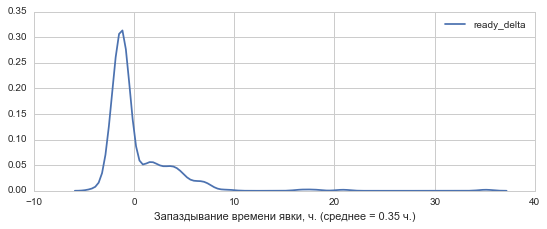

In [475]:
real_pres = team_info[team_info.state.isin(['1', '2', '5'])][['team', 'presence', 'presence_norm']]
a = team_plan[(team_plan.state == 2) & (team_plan.team.isin(real_pres.team))].drop_duplicates('team')
real_pres_fail = a[a.time_start != a.presence][['team', 'time_start', 'time_start_f', 'state_info', 'presence', 'presence_norm']]
if real_pres_fail.empty:
    add_header('Для всех бригад в состояниях 1, 2, 5 явки запланированы верно')
else:
    add_header('Всего %d бригад в состояниях 1, 2, 5, для которых возвращена неверная первая явка. Примеры:' 
               % real_pres_fail.team.count())
    add_line(real_pres_fail.head(10))
    add_line('\nРаспределение по состояниям:')
    add_line(real_pres_fail.state_info.value_counts())
    team_id = real_pres_fail.iloc[0].team
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    add_line(team_plan[team_plan.team == team_id][cols])
    real_pres_fail['ready_delta'] = real_pres_fail.time_start - real_pres_fail.presence
    fig = plt.figure(figsize=(8, 3))    
    #fig = plt.figure()
    sns.set(style='whitegrid', context='notebook')
    sns.kdeplot(real_pres_fail.ready_delta / 3600)
    plt.xlabel('Запаздывание времени явки, ч. (среднее = %.2f ч.)' % np.mean(real_pres_fail.ready_delta / 3600))
    filename = 'team125_ready_late.png'
    fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
    add_image(filename)

Для бригад в начальных состояниях 6 (прибыла на станцию с локомотивом), 7 (прибыла на станцию пассажиром), 9 (сдача локомотива) проверяем, запланирован ли далее для бригады отдых. Если отдых запланирован, то не сравниваем время явки с исходным - оно будет задано вновь после отдыха. Если отдых не запланирован, то явка должна быть возвращена.

Для всех бригад в состояниях 6, 7, 9 запланированы требуемые явки

Всего 12 бригад в состояниях 6, 7, 9, для которых возвращена неверная первая явка. Примеры:
         team  time_start   time_start_f state_info    presence  presence_norm
 200200105777  1470942360  Aug 11, 22:06          6  1470899400  Aug 11, 10:10
 200200216511  1470942259  Aug 11, 22:04          6  1470919500  Aug 11, 15:45
 200200277392  1470941400  Aug 11, 21:50          6  1470912300  Aug 11, 13:45
 200200260678  1470962718  Aug 12, 03:45          6  1470904500  Aug 11, 11:35
 200200249784  1470966660  Aug 12, 04:51          6  1470887400  Aug 11, 06:50

Распределение по состояниям:
6    12
         team         st_from_name           st_to_name   time_start_f     time_end_f  state          loco
 200200105777                 ЗИМА                 ЗИМА  Aug 11, 10:10  Aug 11, 10:50      2            -1
 200200105777            СУХОВСКАЯ                МЕГЕТ  Aug 11, 20:51  Aug 11, 21:00      0            -1
 2002001

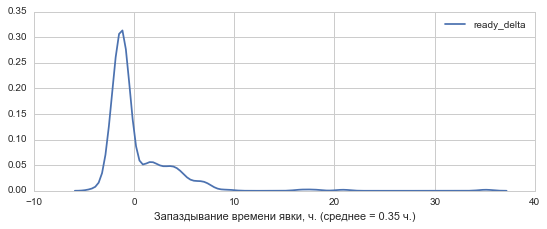

In [476]:
real_pres = team_info[team_info.state.isin(['6', '7', '9'])]
tp = team_plan[(team_plan.team.isin(real_pres.team)) & (team_plan.all_states.apply(lambda x: 4 not in x))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех бригад в состояниях 6, 7, 9 запланированы требуемые явки')
else:
    add_header('Для %d бригад в исходных состояниях 6, 7, 9 не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())    
    add_line('\nРаспределение по состояниям:')
    add_line(tp_no_ready.drop_duplicates('team').state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])
    
tp_ready_time_fail = tp[(tp.state == 2) & (tp.time_start != tp.presence)].drop_duplicates('team')
if tp_ready_time_fail.empty:
    add_header('Для всех бригад в состояниях 6, 7, 9 явки запланированы верно')
else:
    add_header('\nВсего %d бригад в состояниях 6, 7, 9, для которых возвращена неверная первая явка. Примеры:' 
               % tp_ready_time_fail.team.count())
    cols = ['team', 'time_start', 'time_start_f', 'state_info', 'presence', 'presence_norm']
    add_line(tp_ready_time_fail[cols].head())
    add_line('\nРаспределение по состояниям:')
    add_line(tp_ready_time_fail.state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_ready_time_fail.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])
    fig = plt.figure(figsize=(8, 3))            
    sns.kdeplot(real_pres_fail.ready_delta / 3600)
    plt.xlabel('Запаздывание времени явки, ч. (среднее = %.2f ч.)' % np.mean(real_pres_fail.ready_delta / 3600))
    filename = 'team679_ready_late.png'
    fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
    add_image(filename)

In [477]:
tp = team_plan[(team_plan.state_info.isin(['3', '4'])) & (team_plan.all_states.apply(lambda x: (x[0] != 0) & (1 in x)))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех бригад в состояниях 3, 4 запланированы требуемые явки')
else:
    add_header('Для %d бригад в исходных состояниях 3, 4 не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())    
    add_line('\nРаспределение по состояниям:')
    add_line(tp_no_ready.drop_duplicates('team').state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])

Для всех бригад в состояниях 3, 4 запланированы требуемые явки


In [478]:
tp = team_plan[(team_plan.team_type == 'Фейковая') & (team_plan.all_states.apply(lambda x: (x[0] != 0) & (1 in x)))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех фейковых бригад запланированы требуемые явки')
else:
    add_header('Для %d фейковых бригад не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())        
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])

Для 347 фейковых бригад не запланированы явки. Примеры:
         team loc_name state_info all_states
 777700019641      NaN        NaN  [1, 4, 0]
 777700019648      NaN        NaN        [1]
 777700019650      NaN        NaN  [1, 4, 0]
 777700019653      NaN        NaN  [1, 4, 0]
 777700019652      NaN        NaN  [1, 4, 0]
         team st_from_name st_to_name   time_start_f     time_end_f  state          loco
 777700019641     ИЛАНСКАЯ  ЗАОЗЕРНАЯ  Aug 12, 08:06  Aug 12, 10:05      1  200200079854
 777700019641    ЗАОЗЕРНАЯ        УЯР  Aug 12, 10:05  Aug 12, 10:46      1  200200079854
 777700019641          УЯР    КИЛЬЧУГ  Aug 12, 12:30  Aug 12, 13:40      1  200200099573
 777700019641      КИЛЬЧУГ   САЯНСКАЯ  Aug 12, 13:40  Aug 12, 13:58      1  200200099573
 777700019641     САЯНСКАЯ   САЯНСКАЯ  Aug 12, 14:28  Aug 12, 18:48      4            -1
 777700019641     САЯНСКАЯ    КИЛЬЧУГ  Aug 12, 18:48  Aug 12, 19:45      0            -1
 777700019641      КИЛЬЧУГ        УЯР  Aug 12, 19:4

[ToC](#toc)
## Проверка планирования УТХ бригад

Если для какого-то депо приписки переданы бригады с признаком `uth(1)`, то такие бригады должны планироваться в первую очередь, и только после них должны планироваться бригады с признаком `uth(0)`. Для бригад с признаком `uth(0)` должен производиться сдвиг явки на время после максимального времени явки бригад с `uth(1)` для данного депо. Если бригад с `uth(1)` для данного депо не передано, то сдвиг производить не требуется.

In [479]:
add_header('Проверка планирования УТХ-бригад', h=2, p=False)

### УТХ-бригады должны планироваться раньше не-УТХ бригад, начальное состояние которых = 3

In [480]:
print(nice_time(current_time))
uth_depots = team_info[team_info.uth == 1].depot.unique()
cols = ['team', 'depot_name', 'uth', 'time_start_f', 'state']

t_ready_max = team_info[(team_info.uth == 1)].groupby('depot').presence.max()
t_plan_max = team_plan[(team_plan.uth == 1) 
                       & (team_plan.state.isin([0, 1]))].drop_duplicates('team').groupby('depot').time_start.max()
team_plan['uth_plan_max_time'] = team_plan.depot.map(t_plan_max)
team_plan['uth_plan_max_time_f'] = team_plan.uth_plan_max_time.apply(nice_time)
team_plan['uth_ready_max_time'] = team_plan.depot.map(t_ready_max)
team_plan['uth_ready_max_time_f'] = team_plan.uth_ready_max_time.apply(nice_time)
cols = ['team', 'depot_name', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 
        'uth_plan_max_time_f', 'uth_ready_max_time_f']
t_uth_soft_fail = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') & (team_plan.depot.isin(uth_depots))
                      & (team_plan.state.isin([0, 1])) & (team_plan.time_start < team_plan.uth_plan_max_time)
                      & (team_plan.depot_name == team_plan.loc_name)].drop_duplicates('team')
t_uth_hard_fail = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') & (team_plan.depot.isin(uth_depots))
                      & (team_plan.state.isin([0, 1])) & (team_plan.time_start < team_plan.uth_ready_max_time)
                      & (team_plan.depot_name == team_plan.loc_name)].drop_duplicates('team')

total_uth_depots = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') 
                             & (team_plan.depot.isin(uth_depots))].team.drop_duplicates().count()

t_uth_fail_diff_depot_n = t_uth_soft_fail[t_uth_soft_fail.depot_name != t_uth_soft_fail.st_from_name].team.count()

if t_uth_soft_fail.empty:
    add_header('Нет случаев, когда не-УТХ-бригада планируется раньше УТХ-бригады')
else:
    add_header('Всего %d не-УТХ-бригад (%.2f%%), которые отправлены ранее самой поздней УТХ-бригады' 
               % (t_uth_soft_fail.team.count(), 100 * t_uth_soft_fail.team.count() / total_uth_depots))
    add_header('-- из них %d бригад, у которых место явки не совпадает с депо приписки' % t_uth_fail_diff_depot_n)
    add_line('\nРаспределение по депо (первые 5):')
    add_line(t_uth_soft_fail.depot_name.value_counts().head(10))
    add_line('\nПримеры бригад (первые 10 по времени отправления):')
    add_line(t_uth_soft_fail[t_uth_soft_fail.depot_name == t_uth_soft_fail.st_from_name].head(10)[cols])    

Aug 11, 19:31
Всего 173 не-УТХ-бригад (43.03%), которые отправлены ранее самой поздней УТХ-бригады
-- из них 2 бригад, у которых место явки не совпадает с депо приписки

Распределение по депо (первые 5):
МОГОЧА       20
ХИЛОК        15
ЧИТА I       13
РУЖИНО       12
ВИХОРЕВКА    11
УССУРИЙСК    10
УЛАН-УДЭ     10
ТЫНДА         9
АБАКАН        8
ТАЙШЕТ        8

Примеры бригад (первые 10 по времени отправления):
         team           depot_name         st_from_name   st_to_name   time_start_f  state uth_plan_max_time_f uth_ready_max_time_f
 200200224130               РУЖИНО               РУЖИНО     ШМАКОВКА  Aug 13, 09:33      1       Aug 13, 18:45        Aug 12, 17:24
 200200216523  ИРКУТСК-СОРТИРОВ...  ИРКУТСК-СОРТИРОВ...   БАТАРЕЙНАЯ  Aug 13, 02:10      0       Aug 22, 05:15        Aug 12, 17:57
 200200224181               МОГОЧА               МОГОЧА  КСЕНЬЕВСКАЯ  Aug 12, 20:10      1       Aug 14, 19:27        Aug 12, 12:00
 200200206748  ЧЕРНЫШЕВСК-ЗАБАЙ...  ЧЕРНЫШЕВСК-ЗАБАЙ... 

In [481]:
if t_uth_hard_fail.empty:
    add_header('Нет случаев, когда не-УТХ-бригада планируется раньше явки УТХ-бригады')
else:
    add_header('Всего %d не-УТХ-бригад (%.2f%%), которые отправлены ранее самой поздней явки УТХ-бригады' 
               % (t_uth_hard_fail.team.count(), 100 * t_uth_hard_fail.team.count() / total_uth_depots))
    add_header('-- из них %d бригад, у которых место явки не совпадает с депо приписки' % t_uth_fail_diff_depot_n)
    add_line('\nРаспределение по депо (первые 5):')
    add_line(t_uth_hard_fail.depot_name.value_counts().head(10))
    add_line('\nПримеры бригад (первые 10 по времени отправления):')
    add_line(t_uth_hard_fail[t_uth_hard_fail.depot_name == t_uth_hard_fail.st_from_name].head(10)[cols])    

Всего 1 не-УТХ-бригад (0.25%), которые отправлены ранее самой поздней явки УТХ-бригады
-- из них 2 бригад, у которых место явки не совпадает с депо приписки

Распределение по депо (первые 5):
УССУРИЙСК    1

Примеры бригад (первые 10 по времени отправления):
         team depot_name st_from_name   st_to_name   time_start_f  state uth_plan_max_time_f uth_ready_max_time_f
 200200282913  УССУРИЙСК    УССУРИЙСК  БАРАНОВСКИЙ  Aug 12, 12:05      1       Aug 12, 20:30        Aug 12, 15:15


### Проверка УТХ-бригад по одной станции

In [482]:
#st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
st_name = 'СЛЮДЯНКА I'

In [483]:
add_header('Проверка УТХ-бригад по депо %s' % st_name, h=2, p=False)

In [484]:
team_info['depot_name'] = team_info.depot.map(st_names.name)

#team_info.columns
team_info['plan_start_time'] = team_info.team\
                        .map(team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').set_index('team').time_start)
team_info['plan_start_time_f'] = team_info['plan_start_time'].apply(nice_time)

In [485]:
irk_uth = team_info[(team_info.depot_name == st_name) & (team_info.uth == 1)]
add_header('Все УТХ-бригады из депо %s (%d):' % (st_name, irk_uth.team.count()))
cols = ['team', 'depot_name', 'uth', 'state', 'is_assign', 'presence_norm', 'plan_start_time_f']
pd.set_option('display.max_colwidth', 50)
add_line(irk_uth.sort_values('presence')[cols])
t_max = irk_uth.presence.max()
t_plan_max = irk_uth.plan_start_time.max()
add_line('Максимальное время явки УТХ-бригад депо %s: %s' % (st_name, nice_time(t_max)))
add_line('Максимальное время отправления УТХ-бригад депо %s: %s' % (st_name, nice_time(t_plan_max)))

Все УТХ-бригады из депо СЛЮДЯНКА I (29):
         team  depot_name  uth state is_assign  presence_norm plan_start_time_f
 200200260408  СЛЮДЯНКА I    1     8     False  Aug 11, 10:30                  
 200200251109  СЛЮДЯНКА I    1     1      True  Aug 11, 13:10     Aug 11, 19:15
 200200165310  СЛЮДЯНКА I    1     0     False  Aug 11, 15:50                  
 200200233468  СЛЮДЯНКА I    1     1      True  Aug 11, 18:30     Aug 11, 19:04
 200200281158  СЛЮДЯНКА I    1     3      True  Aug 11, 21:18     Aug 13, 00:29
 200200254924  СЛЮДЯНКА I    1     3     False  Aug 11, 21:18                  
 200200220332  СЛЮДЯНКА I    1     3      True  Aug 11, 21:18     Aug 16, 20:51
 200200214542  СЛЮДЯНКА I    1     3      True  Aug 11, 21:18     Aug 13, 02:34
 200200220311  СЛЮДЯНКА I    1     3      True  Aug 11, 21:18     Aug 14, 04:00
 200200262615  СЛЮДЯНКА I    1     3     False  Aug 11, 21:42                  
 200200198214  СЛЮДЯНКА I    1     3     False  Aug 12, 01:58                  

In [486]:
cols = ['team', 'depot_name', 'depot_st_name', 'uth', 'state', 'loc_name', 'is_assign', 'presence_norm', 'plan_start_time_f']
irk_no_uth = team_info[(team_info.depot_name == st_name) & (team_info.uth == 0) & (team_info.state == '3')]
irk_no_uth.loc_name.value_counts()

СЛЮДЯНКА I    38
Name: loc_name, dtype: int64

In [487]:
print(irk_no_uth[irk_no_uth.loc_name == irk_no_uth.depot_name].plan_start_time.min() > t_max)
print(irk_no_uth[irk_no_uth.loc_name == irk_no_uth.depot_name].plan_start_time.min() > t_plan_max)

True
False


In [488]:
irk_no_uth[irk_no_uth.loc_name != irk_no_uth.depot_name][cols]

,team,depot_name,depot_st_name,uth,state,loc_name,is_assign,presence_norm,plan_start_time_f


In [489]:
cols = ['team', 'st_from_name', 'loc_name', 'state', 'presence_norm', 'time_start_f', 'uth', 'delta']
team_plan['delta'] = team_plan.time_start - team_plan.presence
add_header('Все запланированные бригады, отправленные со станции %s из начального state = 3' % st_name)
tp = team_plan[(team_plan.depot_name == st_name) 
          & (team_plan.state_info == '3') 
          & (team_plan.state.isin([0, 1]))
          & (team_plan.loc_name == st_name)]
add_line(tp.drop_duplicates('team').sort_values('time_start')[cols])

Все запланированные бригады, отправленные со станции СЛЮДЯНКА I из начального state = 3
         team st_from_name    loc_name  state  presence_norm   time_start_f  uth   delta
 200200038889   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 11, 16:17  Aug 12, 22:45    0  109680
 200200248159   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 11, 16:22  Aug 12, 23:17    0  111320
 200200281158   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 11, 21:18  Aug 13, 00:29    1   97860
 200200261358   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 11, 16:53  Aug 13, 01:33    0  117620
 200200214542   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 11, 21:18  Aug 13, 02:34    1  105405
 200200208350  СЛЮДЯНКА II  СЛЮДЯНКА I      1  Aug 11, 16:15  Aug 13, 03:58    0  128589
 200200249276   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 11, 20:30  Aug 13, 10:57    0  138453
 200200223542   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 12, 13:40  Aug 13, 17:26    1   99944
 200200091032   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Aug 11, 22:03  Aug 16, 19:49    0  424001
 200200220332   СЛЮДЯН

In [490]:
(tp[tp.uth == 1].drop_duplicates('team').delta / 3600).describe()

count      4.000000
mean      50.944097
std       45.746916
min       27.183333
25%       27.617500
50%       28.520694
75%       51.847292
max      119.551667
Name: delta, dtype: float64

### Для бригад из депо, по которым нет УТХ-бригад, не должно быть большого сдвига времени явки

In [491]:
team_plan['depot_time_f'] = team_plan.depot_time.apply(nice_time)
ts = team_plan[(team_plan.uth == 0) & (team_plan.depot.isin(uth_depots) == False) & (team_plan.state_info == '3')].copy()
ts['delta'] = ts.time_start - ts.depot_time
cols = ['team', 'st_from_name', 'loc_name', 'depot_name', 'time_start_f', 'depot_time_f', 'delta']
ts.drop_duplicates('team')[cols]
delta75 = (ts.drop_duplicates('team').delta / 3600).describe()['75%']
if delta75 < 5:
    add_header('У 75% бригад из депо, по которым нет УТХ-бригад, разница между переданным и запланированным временем явки'
              + ' составляет меньше %.2f ч. (это ОК)' % delta75)
else:
    add_header('WARNING: разница между планируемым и переданным временем явки у бригад из депо, по которым нет УТХ-бригад' +
              'выглядит завышенной')
    ts[ts.delta > 5].sort_values('delta', ascending=False).head(10)[cols]

У 75% бригад из депо, по которым нет УТХ-бригад, разница между переданным и запланированным временем явки составляет меньше 2.96 ч. (это ОК)


### План проверок порядка отправления бригад

1. Взять станцию (Слюдянка - с ней проще, поскольку, вроде бы, нет бригад депо Слюдянка, которые находятся на других станциях), собрать все бригады, которые на начало планирования находились на этой станции.
2. Собрать все бригады, у которых запланирован отдых на этой станции. Рассчитать время выхода с отдыха (можно грубо: +3 часа от времени прибытия).
3. Выстроить эти бригады в порядке готовности к отправлению из Слюдянки. Нужные параметры: депо приписки, участки обкатки, время готовности.
4. Составить список поездов (и их локомотивов), которые проходят через Слюдянку и у которых запланирована смена бригады в Слюдянке. Выстроить эти поезда по времени прибытия в Слюдянку.
5. Сличить два списка. Найти случаи, когда бригады привязываются "вразнобой". Исследовать значения функций полезности. Найти распределение времен ожидания бригад, стоянок и пр.

In [492]:
team_id = team_info[team_info.number.apply(lambda x: '3856' in str(x))].team.values[0]
team_info['rest_time_f'] = team_info.rest_time.apply(nice_time)
info_cols = ['team', 'number', 'oper_time_f', 'rest_time_f', 'loc_name', 'state', 'loco', 'ttype']
add_line(team_info[team_info.team == team_id][info_cols])
plan_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
team_plan[team_plan.team == team_id][plan_cols]

         team      number    oper_time_f rest_time_f                           loc_name state          loco  ttype
 200200224628  9205003856  Aug 11, 17:44              ИРКУТСК-СОРТИРОВОЧНЫЙ - ГОНЧАРОВО     1  200200079623      1


,team,st_from_name,st_to_name,time_start_f,time_end_f,state,loco
2178,200200224628,ИРКУТСК-СОРТИРОВОЧНЫЙ,ИРКУТСК-СОРТИРОВОЧНЫЙ,"Aug 11, 17:40","Aug 11, 19:34",2,-1
2179,200200224628,ИРКУТСК-СОРТИРОВОЧНЫЙ,ГОНЧАРОВО,"Aug 11, 17:44","Aug 11, 18:15",1,200200079623
2180,200200224628,ГОНЧАРОВО,БОЛЬШОЙ ЛУГ,"Aug 11, 18:15","Aug 11, 18:58",1,200200079623
2181,200200224628,БОЛЬШОЙ ЛУГ,АНДРИАНОВСКАЯ,"Aug 11, 18:58","Aug 11, 19:58",1,200200079623
2182,200200224628,АНДРИАНОВСКАЯ,АНГАСОЛКА,"Aug 11, 19:58","Aug 11, 20:12",1,200200079623
2183,200200224628,АНГАСОЛКА,СЛЮДЯНКА II,"Aug 11, 20:12","Aug 11, 20:37",1,200200079623
2184,200200224628,СЛЮДЯНКА II,СЛЮДЯНКА I,"Aug 11, 20:37","Aug 11, 20:46",1,200200079623
2185,200200224628,СЛЮДЯНКА I,БАЙКАЛЬСК,"Aug 11, 20:46","Aug 11, 21:37",1,200200079623
2186,200200224628,БАЙКАЛЬСК,МЫСОВАЯ,"Aug 11, 21:37","Aug 11, 23:42",1,200200079623
2187,200200224628,МЫСОВАЯ,УЛАН-УДЭ,"Aug 11, 23:42","Aug 12, 02:23",1,200200079623


## Экспорт в HTML [ToC](#toc)

In [493]:
filename = REPORT_FOLDER + 'team_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/team_report_20160812_154712.html
